In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
warnings.filterwarnings('ignore')

import xgboost as xgb

from sklearn.ensemble import (RandomForestClassifier, AdaBoostClassifier,\
                             GradientBoostingClassifier, ExtraTreesClassifier,\
                             BaggingClassifier, VotingClassifier)

from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC
from sklearn.linear_model import LogisticRegression
from sklearn.linear_model import Perceptron
from sklearn.naive_bayes import GaussianNB
from sklearn.tree import DecisionTreeClassifier
from sklearn.cross_validation import KFold

from sklearn.model_selection import train_test_split
from sklearn.model_selection import cross_val_score
from sklearn.metrics import accuracy_score

from sklearn.metrics import roc_auc_score


from time import time

/home/mariano/ENTER/lib/python3.6/site-packages/sklearn/ensemble/weight_boosting.py:29: DeprecationWarning: numpy.core.umath_tests is an internal NumPy module and should not be imported. It will be removed in a future NumPy release.
  from numpy.core.umath_tests import inner1d
/home/mariano/ENTER/lib/python3.6/site-packages/sklearn/cross_validation.py:41: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. Also note that the interface of the new CV iterators are different from that of this module. This module will be removed in 0.20.
  "This module will be removed in 0.20.", DeprecationWarning)


In [2]:
mejor_precision = 0
mejores_features = 0

# Set de entrenamiento y Test final

Cargamos los archivos necesarios

In [36]:
train = pd.read_csv('train_final.csv')
test = pd.read_csv('test_final.csv')

In [4]:
train.person.count()

19414

In [5]:
test.person.count()

19415

Transformamos las variables categóricas al tipo correspondiente, para reducir el uso de memoria

In [3]:
#train['rango_edad'] = train['rango_edad'].astype('category')
#train['sexo'] = train['sexo'].astype('category') 
#train['nivel_estudios'] = train['nivel_estudios'].astype('category')
#train['esta_estudiando'] = train['esta_estudiando'].astype('category')
#train['tipo_de_trabajo'] = train['tipo_de_trabajo'].astype('category')
#train['nivel_laboral'] = train['nivel_laboral'].astype('category')
#train['nombre_zona'] = train['nombre_zona'].astype('category')
#train['num_area'] = train['num_area'].astype('category')
#train['post_por_nivel'] = train['post_por_nivel'].astype('category')
#train['sepostulo'] = train['sepostulo'].astype('category')

In [4]:
#test_final['rango_edad'] = test_final['rango_edad'].astype('category')
#test_final['sexo'] = test_final['sexo'].astype('category') 
#test_final['nivel_estudios'] = test_final['nivel_estudios'].astype('category')
#test_final['esta_estudiando'] = test_final['esta_estudiando'].astype('category')
#test_final['tipo_de_trabajo'] = test_final['tipo_de_trabajo'].astype('category')
#test_final['nivel_laboral'] = test_final['nivel_laboral'].astype('category')
#test_final['nombre_zona'] = test_final['nombre_zona'].astype('category')
#test_final['num_area'] = test_final['num_area'].astype('category')
#test_final['post_por_nivel'] = test_final['post_por_nivel'].astype('category')

Nos guardamos los IDs necesarios para el submit

In [5]:
#id_aviso_postulante = test_final['id']

Analizamos el set de entrenamiento y el test final

In [41]:
train.sample(5)

,person,brand listing,checkout,conversion,generic listing,searched products,staticpage,viewed product,visited site,label
380,64a3c2f6,14.0,0.0,0.0,1.0,0.0,0.0,13.0,7.0,1.0
705,b866afff,39.0,4.0,2.0,28.0,101.0,2.0,78.0,20.0,1.0
1474,947126c0,0.0,1.0,0.0,2.0,0.0,0.0,2.0,1.0,0.0
160,2b81e8f3,10.0,1.0,1.0,19.0,0.0,0.0,115.0,9.0,1.0
1321,f4924234,1.0,2.0,0.0,0.0,0.0,0.0,20.0,5.0,0.0


In [42]:
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1980 entries, 0 to 1979
Data columns (total 10 columns):
person               1980 non-null object
brand listing        1980 non-null float64
checkout             1980 non-null float64
conversion           1980 non-null float64
generic listing      1980 non-null float64
searched products    1980 non-null float64
staticpage           1980 non-null float64
viewed product       1980 non-null float64
visited site         1980 non-null float64
label                1980 non-null float64
dtypes: float64(9), object(1)
memory usage: 154.8+ KB


In [28]:
test_final.sample(5)

NameError: name 'test_final' is not defined

In [5]:
test_final.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 19414 entries, 0 to 19413
Data columns (total 10 columns):
person               19414 non-null object
label                19414 non-null int64
brand listing        19414 non-null float64
checkout             19414 non-null float64
conversion           19414 non-null float64
generic listing      19414 non-null float64
searched products    19414 non-null float64
staticpage           19414 non-null float64
viewed product       19414 non-null float64
visited site         19414 non-null float64
dtypes: float64(8), int64(1), object(1)
memory usage: 1.5+ MB


In [15]:
from scipy.stats import skew

for i in train.iloc[:,2:].columns:
    print(i+':', round(skew(train[i]),2) ) 

max_tiempo_sesion_q_0: 51.23
max_tiempo_sesion_q_1: 119.15
max_tiempo_sesion_q_2: 95.43
max_tiempo_sesion_q_3: 98.89
max_tiempo_sesion_q_4: 51.3
max_tiempo_sesion_q_5: 91.03
max_tiempo_sesion_q_6: 90.78
max_tiempo_sesion_q_7: 72.72
max_tiempo_sesion_q_8: 47.52
max_tiempo_sesion_q_9: 15.27
prom_tiempo_sesion_q_0: 62.41
prom_tiempo_sesion_q_1: 137.74
prom_tiempo_sesion_q_2: 138.47
prom_tiempo_sesion_q_3: 139.16
prom_tiempo_sesion_q_4: 85.42
prom_tiempo_sesion_q_5: 99.69
prom_tiempo_sesion_q_6: 113.79
prom_tiempo_sesion_q_7: 56.85
prom_tiempo_sesion_q_8: 133.29
prom_tiempo_sesion_q_9: 38.84
viewed product_0: 44.27
viewed product_1: 29.59
viewed product_2: 39.5
viewed product_3: 25.64
viewed product_4: 18.08
viewed product_5: 24.11
viewed product_6: 21.98
viewed product_7: 19.77
viewed product_8: 10.46
viewed product_9: 7.26
searched products_0: 43.21
searched products_1: 25.47
searched products_2: 28.54
searched products_3: 33.04
searched products_4: 24.93
searched products_5: 35.93
searc

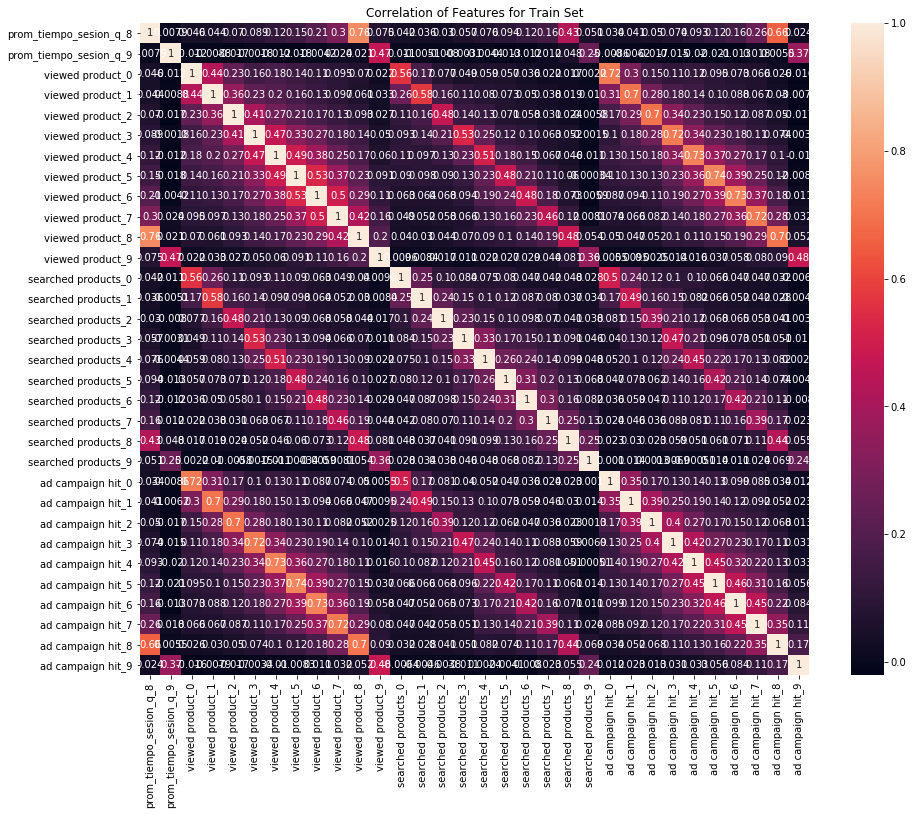

In [6]:
#Finallt, lets look the correlation of df_train
plt.figure(figsize=(15,12))
plt.title('Correlation of Features for Train Set')
sns.heatmap(train[train.iloc[:,20:52].columns].astype(float).corr(),vmax=1.0,  annot=True)
plt.show()

In [37]:
skewed_features = np.array(train.iloc[:,2:].columns)[np.abs(skew(train[train.iloc[:,2:].columns])) > 0.5]
train[skewed_features] = np.log1p(train[skewed_features])

In [38]:
skewed_features = np.array(test.iloc[:,1:].columns)[np.abs(skew(test[test.iloc[:,1:].columns])) > 0.5]
test[skewed_features] = np.log1p(test[skewed_features])

In [6]:
from scipy.stats import skew

# Check the skew of all numerical features
skewed_feats = train[train.iloc[:,2:].columns].apply(lambda x: skew(x.dropna())).sort_values(ascending=False)
print("\nSkew in numerical features: \n")
skewness = pd.DataFrame({'Skew' :skewed_feats})
skewness.head(10)


Skew in numerical features: 



,Skew
lead_0,85.100858
lead_3,60.756448
lead_5,52.675887
lead_4,51.491629
lead_2,49.714320
lead_1,48.797911
conversion_1,36.725487
conversion_0,35.807057
staticpage_0,35.108288
staticpage_3,32.769131


In [4]:
skewness = skewness[abs(skewness) > 0.75]
print("There are {} skewed numerical features to Box Cox transform".format(skewness.shape[0]))

from scipy.special import boxcox1p
skewed_features = skewness.index
lam = 0.15
for feat in skewed_features:
    #all_data[feat] += 1
    train[feat] = boxcox1p(train[feat], lam)

There are 155 skewed numerical features to Box Cox transform


Nos guardamos los features que utilizaremos para los algoritmos de Machine Learning

In [74]:
cantidad_sesiones = []
promedio_tiempo_sesion = []
maxima_sesion = []
compras = []
ad_campaign_hit = []
viewed_product = []
brand_listing = []
checkout = []
generic_listing = []
search_engine_hit = []
searched_products = []
viewed_products = []
visited_site = []
lead = []
for i in range(6,10):
    promedio_tiempo_sesion.append('prom_tiempo_sesion_q_'+str(i))
    maxima_sesion.append('max_tiempo_sesion_q_'+str(i))
    cantidad_sesiones.append('cant_sesiones_q_'+str(i))    
for i in range(6,10):
    compras.append('conversion_'+str(i))
    ad_campaign_hit.append('ad campaign hit_'+str(i))
    viewed_product.append('viewed product_'+str(i))
    visited_site.append('visited site_'+str(i))
    brand_listing.append('brand listing_'+str(i))
    checkout.append('checkout_'+str(i))
    generic_listing.append('generic listing_'+str(i))
    search_engine_hit.append('search engine hit_'+str(i))
    searched_products.append('searched products_'+str(i))
    lead.append('lead_'+str(i))
conversiones_dias_features = ['antiguedad','max_sin_convertir','dias_sin_convertir','convierte_cada_x_dias']

eventos_total = ['ad campaign hit','viewed product','brand listing','checkout','generic listing',\
                 'search engine hit','searched products','conversion'] 
eventos_out = ['lead','staticpage','visited site']

features_nn = maxima_sesion + \
    conversiones_dias_features +  \
    eventos_total + compras
#promedio_tiempo_sesion + cantidad_sesiones  
#+ checkout + ad_campaign_hit + viewed_product + searched_products + search_engine_hit + brand_listing
#+ generic_listing + visited_site\
#checkout + ad_campaign_hit + viewed_product + searched_products + generic_listing + search_engine_hit + brand_listing
features = train.iloc[:,2:].columns

In [84]:
#numero de las columnas para usar en el nn
num_col = []
for i in features_nn:
    num_col.append(train.columns.get_loc(i))
    

0.8379704883687328
eventos + conversionesdias           NN

0.8407473630978183
eventos + conversionesdias + maximasesion + compras       NN

Particionamos el set de entrenamiento para realizar pruebas locales de hiper-parámetros antes de realizar cada submit

In [40]:
test_s = 0.25
random_s = 0

x = np.array(train[train.iloc[:,2:].columns])
y = np.array(train['label'])

x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=test_s, random_state=random_s)

Generamos el set de entrenamiento para el test final

In [61]:
x_test_final = np.array(test[features])

# Algoritmos probados

In [20]:
from sklearn.preprocessing import StandardScaler, RobustScaler


scaler = RobustScaler()

x_train= scaler.fit_transform(x_train)
X_test= scaler.transform(x_test)

In [21]:
from xgboost import XGBRegressor
xgb = XGBRegressor()
xgb.fit(x_train, y_train)
imp = pd.DataFrame(xgb.feature_importances_ ,columns = ['Importance'],index = features)
imp = imp.sort_values(['Importance'], ascending = False)
print(imp)

                       Importance
checkout_9               0.079447
conversion               0.046632
dias_sin_convertir       0.041451
max_tiempo_sesion_q_0    0.034542
checkout                 0.031088
max_sin_convertir        0.029361
viewed product           0.029361
max_tiempo_sesion_q_8    0.025907
convierte_cada_x_dias    0.025907
max_tiempo_sesion_q_9    0.024180
viewed product_9         0.022453
ad campaign hit          0.022453
searched products        0.017271
cant_sesiones_q_1        0.015544
max_tiempo_sesion_q_6    0.015544
checkout_8               0.015544
searched products_9      0.015544
brand listing_1          0.013817
search engine hit        0.013817
viewed product_5         0.013817
generic listing_7        0.013817
search engine hit_9      0.013817
brand listing_8          0.013817
ad campaign hit_9        0.013817
checkout_3               0.013817
checkout_7               0.013817
brand listing_7          0.012090
brand listing            0.012090
visited site_4

In [22]:
from sklearn.feature_selection import RFECV
from sklearn.metrics import make_scorer 


# Define a function to calculate RMSE
def rmse(y_true, y_pred):
    return np.sqrt(np.mean((y_true-y_pred)**2))

# Define a function to calculate negative RMSE (as a score)
def nrmse(y_true, y_pred):
    return -1.0*rmse(y_true, y_pred)

neg_rmse = make_scorer(nrmse)

estimator = XGBRegressor()
selector = RFECV(estimator, cv = 3, n_jobs = -1, scoring = 'roc_auc')
selector = selector.fit(x_train, y_train)

print("The number of selected features is: {}".format(selector.n_features_))

features_kept = features[selector.support_] 

x_train = selector.transform(x_train)  
x_test = selector.transform(x_test)


The number of selected features is: 32


NameError: name 'feature' is not defined

In [13]:
features_kept

Index(['max_tiempo_sesion_q_0', 'max_tiempo_sesion_q_2',
       'max_tiempo_sesion_q_3', 'max_tiempo_sesion_q_4',
       'max_tiempo_sesion_q_5', 'max_tiempo_sesion_q_6',
       'max_tiempo_sesion_q_8', 'max_tiempo_sesion_q_9',
       'prom_tiempo_sesion_q_0', 'prom_tiempo_sesion_q_1',
       'prom_tiempo_sesion_q_3', 'prom_tiempo_sesion_q_6',
       'prom_tiempo_sesion_q_9', 'viewed product_1', 'viewed product_2',
       'viewed product_5', 'viewed product_7', 'viewed product_9',
       'searched products_5', 'searched products_8', 'searched products_9',
       'ad campaign hit_3', 'ad campaign hit_6', 'ad campaign hit_8',
       'ad campaign hit_9', 'staticpage_0', 'staticpage_4', 'staticpage_5',
       'staticpage_7', 'checkout_3', 'checkout_7', 'checkout_8', 'checkout_9',
       'search engine hit_6', 'search engine hit_9', 'conversion_9',
       'generic listing_0', 'generic listing_1', 'generic listing_3',
       'generic listing_7', 'brand listing_1', 'brand listing_2',
       '

In [29]:
from sklearn.base import BaseEstimator, RegressorMixin
from sklearn.kernel_ridge import KernelRidge
from sklearn.linear_model import Lasso, ElasticNet, Ridge

class Ensemble(BaseEstimator, RegressorMixin):
    def __init__(self, regressors=None):
        self.regressors = regressors
        
    def level0_to_level1(self, X):
        self.predictions_ = []

        for regressor in self.regressors:
            self.predictions_.append(regressor.predict(X).reshape(X.shape[0],1))

        return np.concatenate(self.predictions_, axis=1)
    
    def fit(self, X, y):
        for regressor in self.regressors:
            if regressor != nn:
                regressor.fit(X, y)
            else: regressor.fit(X, y, batch_size=64, epochs=1000, verbose=0) # Neural Network
            
        self.new_features = self.level0_to_level1(X)
        
        # using a large L2 regularization to prevent the ensemble from biasing toward 
        # one particular base model
        self.combine = Ridge(alpha=10, max_iter=50000)   
        self.combine.fit(self.new_features, y)

        self.coef_ = self.combine.coef_

    def predict(self, X):
        self.new_features = self.level0_to_level1(X)
        return self.combine.predict(self.new_features).reshape(X.shape[0])


In [ ]:
import keras 
from keras.models import Sequential # intitialize the ANN
from keras.layers import Dense      # create layers
from sklearn.ensemble import GradientBoostingRegressor

# Parámetros óptimos
params_optimos_gb = {'criterion': 'friedman_mse','learning_rate':0.2, 'n_estimators':10, 'max_depth':5,\
                     'min_samples_split':0.5,'min_samples_leaf':0.1, 'subsample':0.9, 'max_features':'sqrt',\
                     } #'loss': 'deviance'

# Creamos el gradient boosting
gra_boost = GradientBoostingRegressor(**params_optimos_gb)

naive_bayes = GaussianNB()

# Initialising the NN
nn = Sequential()

# layers
nn.add(Dense(units = 9, kernel_initializer = 'uniform', activation = 'relu', input_dim = len(features_kept)))
nn.add(Dense(units = 9, kernel_initializer = 'uniform', activation = 'relu'))
nn.add(Dense(units = 5, kernel_initializer = 'uniform', activation = 'relu'))
nn.add(Dense(units = 1, kernel_initializer = 'uniform', activation = 'sigmoid'))

# Compiling the ANN
nn.compile(optimizer = 'adam', loss = 'binary_crossentropy', metrics = ['accuracy'])

xgb = XGBRegressor(base_score=0.5, booster='gbtree', colsample_bylevel=1,\
       colsample_bytree=0.6, gamma=5, learning_rate=0.02, max_delta_step=0,\
       max_depth=5, min_child_weight=5, missing=None, n_estimators=600,\
       n_jobs=1, nthread=1, objective='binary:logistic', random_state=0,\
       reg_alpha=0, reg_lambda=1, scale_pos_weight=1, seed=None,\
       silent=True, subsample=1.0)
ridge = KernelRidge(alpha=0.15, coef0=3.7, degree=2, kernel='polynomial')


model = Ensemble(regressors=[xgb,nn,naive_bayes,gra_boost,ridge])
model.fit(x_train, y_train)
y_pred = np.exp(model.predict(x_test))

print("\nThe weights of the five base models are: {}".format(model.coef_))
print(roc_auc_score(y_test,y_pred))

### Majority Voting


In [90]:
import keras 
from keras.models import Sequential # intitialize the ANN
from keras.layers import Dense      # create layers
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.kernel_ridge import KernelRidge
from sklearn.linear_model import Lasso, ElasticNet, Ridge
params_optimos_gb = {'criterion': 'friedman_mse','learning_rate':0.2, 'n_estimators':10, 'max_depth':5,\
                     'min_samples_split':0.5,'min_samples_leaf':0.1, 'subsample':0.9, 'max_features':'sqrt',\
                     } #'loss': 'deviance'

# Creamos el gradient boosting
gra_boost = GradientBoostingRegressor(**params_optimos_gb)

naive_bayes = GaussianNB()

# Initialising the NN
nn = Sequential()

# layers
nn.add(Dense(units = 9, kernel_initializer = 'uniform', activation = 'relu', input_dim = len(features_nn)))
nn.add(Dense(units = 9, kernel_initializer = 'uniform', activation = 'relu'))
nn.add(Dense(units = 5, kernel_initializer = 'uniform', activation = 'relu'))
nn.add(Dense(units = 1, kernel_initializer = 'uniform', activation = 'sigmoid'))

# Compiling the ANN
nn.compile(optimizer = 'adam', loss = 'binary_crossentropy', metrics = ['accuracy'])

xgb = XGBRegressor(base_score=0.5, booster='gbtree', colsample_bylevel=1,\
       colsample_bytree=0.6, gamma=5, learning_rate=0.02, max_delta_step=0,\
       max_depth=5, min_child_weight=5, missing=None, n_estimators=600,\
       n_jobs=1, nthread=1, objective='binary:logistic', random_state=0,\
       reg_alpha=0, reg_lambda=1, scale_pos_weight=1, seed=None,\
       silent=True, subsample=1.0)
ridge = KernelRidge(alpha=0.15, coef0=3.7, degree=2, kernel='polynomial')

ridge.fit(x_train,y_train)
gra_boost.fit(x_train,y_train)
naive_bayes.fit(x_train,y_train)
xgb.fit(x_train,y_train)
nn.fit(x_train[:,num_col], y_train, batch_size = 32, epochs = 200)


ValueError: Error when checking input: expected dense_21_input to have shape (20,) but got array with shape (155,)

In [100]:
# Initialising the NN
nn = Sequential()

# layers
nn.add(Dense(units = 9, kernel_initializer = 'uniform', activation = 'relu', input_dim = len(num_col)))
nn.add(Dense(units = 9, kernel_initializer = 'uniform', activation = 'relu'))
nn.add(Dense(units = 5, kernel_initializer = 'uniform', activation = 'relu'))
nn.add(Dense(units = 1, kernel_initializer = 'uniform', activation = 'sigmoid'))

# Compiling the ANN
nn.compile(optimizer = 'adam', loss = 'binary_crossentropy', metrics = ['accuracy'])
nn.fit(x_train[:,num_col], y_train, batch_size = 32, epochs = 200)


Epoch 1/200
14560/14560 [==============================] - 1s 70us/step - loss: 0.3266 - acc: 0.9481
Epoch 2/200
14560/14560 [==============================] - 1s 35us/step - loss: 0.2118 - acc: 0.9492
Epoch 3/200
14560/14560 [==============================] - 0s 34us/step - loss: 0.1978 - acc: 0.9492
Epoch 4/200
14560/14560 [==============================] - 0s 34us/step - loss: 0.1884 - acc: 0.9492
Epoch 5/200
14560/14560 [==============================] - 1s 35us/step - loss: 0.1826 - acc: 0.9492
Epoch 6/200
14560/14560 [==============================] - 1s 38us/step - loss: 0.1795 - acc: 0.9492
Epoch 7/200
14560/14560 [==============================] - 1s 35us/step - loss: 0.1779 - acc: 0.9492
Epoch 8/200
14560/14560 [==============================] - 0s 33us/step - loss: 0.1770 - acc: 0.9492
Epoch 9/200
14560/14560 [==============================] - 0s 34us/step - loss: 0.1763 - acc: 0.9492
Epoch 10/200
14560/14560 [==============================] - 1s 36us/step - loss: 0.1756 - a

14560/14560 [==============================] - 1s 39us/step - loss: 0.1681 - acc: 0.9492
Epoch 161/200
14560/14560 [==============================] - 1s 41us/step - loss: 0.1678 - acc: 0.9492
Epoch 162/200
14560/14560 [==============================] - 1s 39us/step - loss: 0.1677 - acc: 0.9492
Epoch 163/200
14560/14560 [==============================] - 1s 40us/step - loss: 0.1678 - acc: 0.9492
Epoch 164/200
14560/14560 [==============================] - 1s 40us/step - loss: 0.1677 - acc: 0.9492
Epoch 165/200
14560/14560 [==============================] - 1s 38us/step - loss: 0.1672 - acc: 0.9492
Epoch 166/200
14560/14560 [==============================] - 1s 42us/step - loss: 0.1673 - acc: 0.9492
Epoch 167/200
14560/14560 [==============================] - 1s 40us/step - loss: 0.1669 - acc: 0.9492
Epoch 168/200
14560/14560 [==============================] - 0s 34us/step - loss: 0.1666 - acc: 0.9492
Epoch 169/200
14560/14560 [==============================] - 0s 34us/step - loss: 0.166

In [102]:
Y_pred = pd.DataFrame({'person' : y_test})
Y_pred['gra_boost'] = gra_boost.predict(x_test)
Y_pred['xgb'] = xgb.predict(x_test)
Y_pred['nn'] = nn.predict(x_test[:,num_col])

In [111]:
Y_pred['label'] = 0
Y_pred['label'] = Y_pred.iloc[:, 1:3].mode(axis=1)

In [112]:
roc_auc_score(y_test,Y_pred['label'])

0.8520165077300969

## Neural Network

Mejor precision = 0.8488016543852044
Features = eventos_total + todos los demas desde el 6 + conversiones_dias

### Set de entrenamiento

In [19]:
import keras 
from keras.models import Sequential # intitialize the ANN
from keras.layers import Dense      # create layers

# Initialising the NN
model = Sequential()

# layers
model.add(Dense(units = 9, kernel_initializer = 'uniform', activation = 'relu', input_dim = len(features)))
model.add(Dense(units = 9, kernel_initializer = 'uniform', activation = 'relu'))
model.add(Dense(units = 5, kernel_initializer = 'uniform', activation = 'relu'))
model.add(Dense(units = 1, kernel_initializer = 'uniform', activation = 'sigmoid'))

# Compiling the ANN
model.compile(optimizer = 'adam', loss = 'binary_crossentropy', metrics = ['accuracy'])

# Train the ANN
model.fit(x_train, y_train, batch_size = 32, epochs = 200)

Epoch 1/200
14560/14560 [==============================] - 2s 105us/step - loss: 0.3241 - acc: 0.9492
Epoch 2/200
14560/14560 [==============================] - 0s 33us/step - loss: 0.1895 - acc: 0.9492
Epoch 3/200
14560/14560 [==============================] - 0s 33us/step - loss: 0.1770 - acc: 0.9492
Epoch 4/200
14560/14560 [==============================] - 0s 33us/step - loss: 0.1727 - acc: 0.9492
Epoch 5/200
14560/14560 [==============================] - 0s 33us/step - loss: 0.1713 - acc: 0.9492
Epoch 6/200
14560/14560 [==============================] - 0s 33us/step - loss: 0.1698 - acc: 0.9492
Epoch 7/200
14560/14560 [==============================] - 0s 33us/step - loss: 0.1690 - acc: 0.9492
Epoch 8/200
14560/14560 [==============================] - 0s 33us/step - loss: 0.1686 - acc: 0.9492
Epoch 9/200
14560/14560 [==============================] - 0s 33us/step - loss: 0.1679 - acc: 0.9492
Epoch 10/200
14560/14560 [==============================] - 0s 33us/step - loss: 0.1671 - 

KeyboardInterrupt: 

In [63]:
y_pred = model.predict(x_test)
precision = roc_auc_score(y_test,y_pred)
precision

0.8019830949284785

In [235]:
if precision >= mejor_precision:
    mejor_precision = precision
    mejores_features = features

In [236]:
mejor_precision

0.8488016543852044

In [237]:
mejores_features

['ad campaign hit',
 'brand listing',
 'checkout',
 'generic listing',
 'search engine hit',
 'searched products',
 'viewed product',
 'max_tiempo_sesion_q_6',
 'max_tiempo_sesion_q_7',
 'max_tiempo_sesion_q_8',
 'max_tiempo_sesion_q_9',
 'antiguedad',
 'max_sin_convertir',
 'dias_sin_convertir',
 'convierte_cada_x_dias',
 'conversion',
 'prom_tiempo_sesion_q_6',
 'prom_tiempo_sesion_q_7',
 'prom_tiempo_sesion_q_8',
 'prom_tiempo_sesion_q_9',
 'cant_sesiones_q_6',
 'cant_sesiones_q_7',
 'cant_sesiones_q_8',
 'cant_sesiones_q_9',
 'compras_q_6',
 'compras_q_7',
 'compras_q_8',
 'compras_q_9']

LogReg: 0.797569 (+/- 0.017132)
XGBClassifier: 0.848423 (+/- 0.007455)
KNN: 0.680115 (+/- 0.016332)
DecisionTreeClassifier: 0.583096 (+/- 0.012935)
RandomForestClassifier: 0.741675 (+/- 0.013270)
GradientBoostingClassifier: 0.846338 (+/- 0.008587)
RidgeClassifier: 0.794571 (+/- 0.016418)
BaggingRidgeClassifier: 0.746370 (+/- 0.013195)
ExtraTreesClassifier: 0.724290 (+/- 0.016440)


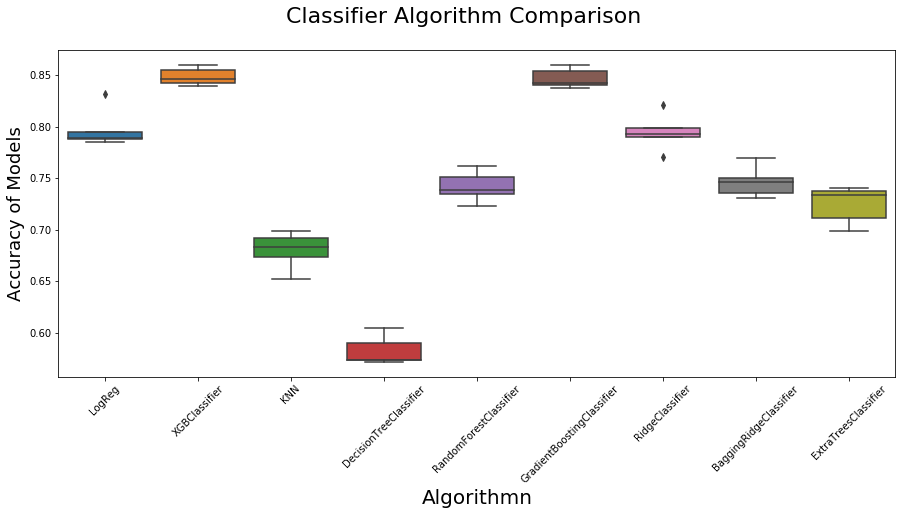

In [16]:
#Importing the auxiliar and preprocessing librarys 
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report
from sklearn.cross_validation import cross_val_score
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.pipeline import Pipeline

from sklearn.model_selection import train_test_split, KFold, cross_validate
from sklearn.metrics import accuracy_score

#Models
from sklearn.cluster import KMeans
from sklearn.decomposition import PCA
from sklearn.svm import SVC
from sklearn.linear_model import RidgeClassifier, SGDClassifier, LogisticRegression
from sklearn.svm import SVC, LinearSVC
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from xgboost import XGBClassifier
from sklearn.naive_bayes import MultinomialNB
from sklearn.feature_selection import SelectFromModel
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier, ExtraTreesClassifier, BaggingClassifier, VotingClassifier, RandomTreesEmbedding

clfs = []
seed = 3

clfs.append(("LogReg", 
             Pipeline([("Scaler", StandardScaler()),
                       ("LogReg", LogisticRegression())])))

clfs.append(("XGBClassifier",
             Pipeline([("Scaler", StandardScaler()),
                       ("XGB", XGBClassifier())]))) 
clfs.append(("KNN", 
             Pipeline([("Scaler", StandardScaler()),
                       ("KNN", KNeighborsClassifier())]))) 

clfs.append(("DecisionTreeClassifier", 
             Pipeline([("Scaler", StandardScaler()),
                       ("DecisionTrees", DecisionTreeClassifier())]))) 

clfs.append(("RandomForestClassifier", 
             Pipeline([("Scaler", StandardScaler()),
                       ("RandomForest", RandomForestClassifier())]))) 

clfs.append(("GradientBoostingClassifier", 
             Pipeline([("Scaler", StandardScaler()),
                       ("GradientBoosting", GradientBoostingClassifier(max_features=15, n_estimators=150))]))) 
clfs.append(("RidgeClassifier", 
             Pipeline([("Scaler", StandardScaler()),
                       ("RidgeClassifier", RidgeClassifier())])))

clfs.append(("BaggingRidgeClassifier",
             Pipeline([("Scaler", StandardScaler()),
                       ("BaggingClassifier", BaggingClassifier())])))

clfs.append(("ExtraTreesClassifier",
             Pipeline([("Scaler", StandardScaler()),
                       ("ExtraTrees", ExtraTreesClassifier())])))

#'neg_mean_absolute_error', 'neg_mean_squared_error','r2'
scoring = 'roc_auc'
n_folds = 7

results, names  = [], [] 

for name, model  in clfs:
    kfold = KFold(n_splits=n_folds, random_state=seed)
    cv_results = cross_val_score(model, x_train, y_train, cv= 5, scoring=scoring, n_jobs=-1)    
    names.append(name)
    results.append(cv_results)    
    msg = "%s: %f (+/- %f)" % (name, cv_results.mean(),  cv_results.std())
    print(msg)
    
# boxplot algorithm comparison
fig = plt.figure(figsize=(15,6))
fig.suptitle('Classifier Algorithm Comparison', fontsize=22)
ax = fig.add_subplot(111)
sns.boxplot(x=names, y=results)
ax.set_xticklabels(names)
ax.set_xlabel("Algorithmn", fontsize=20)
ax.set_ylabel("Accuracy of Models", fontsize=18)
ax.set_xticklabels(ax.get_xticklabels(),rotation=45)
plt.show()

### Prediccion del test final

In [240]:
# Initialising the NN
model = Sequential()

# layers
model.add(Dense(units = 9, kernel_initializer = 'uniform', activation = 'relu', input_dim = len(features)))
model.add(Dense(units = 9, kernel_initializer = 'uniform', activation = 'relu'))
model.add(Dense(units = 5, kernel_initializer = 'uniform', activation = 'relu'))
model.add(Dense(units = 1, kernel_initializer = 'uniform', activation = 'sigmoid'))

# Compiling the ANN
model.compile(optimizer = 'adam', loss = 'binary_crossentropy', metrics = ['accuracy'])

# Train the ANN
model.fit(x, y, batch_size = 32, epochs = 200)

Epoch 1/200
19414/19414 [==============================] - 3s 143us/step - loss: 0.2797 - acc: 0.9492
Epoch 2/200
19414/19414 [==============================] - 1s 64us/step - loss: 0.1869 - acc: 0.9495
Epoch 3/200
19414/19414 [==============================] - 1s 65us/step - loss: 0.1801 - acc: 0.9495
Epoch 4/200
19414/19414 [==============================] - 1s 67us/step - loss: 0.1775 - acc: 0.9495
Epoch 5/200
19414/19414 [==============================] - 1s 66us/step - loss: 0.1754 - acc: 0.9495
Epoch 6/200
19414/19414 [==============================] - 1s 67us/step - loss: 0.1740 - acc: 0.9495
Epoch 7/200
19414/19414 [==============================] - 1s 67us/step - loss: 0.1734 - acc: 0.9495
Epoch 8/200
19414/19414 [==============================] - 1s 64us/step - loss: 0.1724 - acc: 0.9495
Epoch 9/200
19414/19414 [==============================] - 1s 69us/step - loss: 0.1719 - acc: 0.9495
Epoch 10/200
19414/19414 [==============================] - 1s 69us/step - loss: 0.1713 - 

19414/19414 [==============================] - 1s 62us/step - loss: 0.1542 - acc: 0.9495
Epoch 161/200
19414/19414 [==============================] - 1s 62us/step - loss: 0.1540 - acc: 0.9495
Epoch 162/200
19414/19414 [==============================] - 1s 60us/step - loss: 0.1544 - acc: 0.9495
Epoch 163/200
19414/19414 [==============================] - 1s 61us/step - loss: 0.1545 - acc: 0.9495
Epoch 164/200
19414/19414 [==============================] - 1s 61us/step - loss: 0.1537 - acc: 0.9495
Epoch 165/200
19414/19414 [==============================] - 1s 61us/step - loss: 0.1540 - acc: 0.9495
Epoch 166/200
19414/19414 [==============================] - 1s 63us/step - loss: 0.1540 - acc: 0.9495
Epoch 167/200
19414/19414 [==============================] - 1s 64us/step - loss: 0.1541 - acc: 0.9495
Epoch 168/200
19414/19414 [==============================] - 1s 61us/step - loss: 0.1545 - acc: 0.9495
Epoch 169/200
19414/19414 [==============================] - 1s 60us/step - loss: 0.154

In [248]:
pred_final = model.predict_proba(x_test_final)


In [249]:
person = np.array(test['person'])

In [250]:
person =person.reshape((19415,1))

In [251]:
submit = pd.DataFrame(data=np.column_stack((person,pred_final)),columns=['person','label'])

#submit = pd.DataFrame({'person':person, 'label':pred_final})

In [252]:



submit.to_csv('submit_nn.csv', index=False)

## XGBRegressor

Mejor resultado = 0.0.8639859666233204

Features desde la quincena 4 + eventos_total + conversiones_dias

### Set de entrenamiento

In [17]:
from xgboost import XGBRegressor

In [64]:
xgb = XGBRegressor(base_score=0.5, booster='gbtree', colsample_bylevel=1,\
       colsample_bytree=0.6, gamma=5, learning_rate=0.02, max_delta_step=0,\
       max_depth=5, min_child_weight=5, missing=None, n_estimators=600,\
       n_jobs=1, nthread=1, objective='binary:logistic', random_state=0,\
       reg_alpha=0, reg_lambda=1, scale_pos_weight=1, seed=None,\
       silent=True, subsample=1.0)


In [65]:
xgb.fit(x_train,y_train)
pred = xgb.predict(x_test)
roc_auc_score(y_test,pred)

0.8606573291431874

### Prediccion del test final

In [44]:
xgb = XGBRegressor(base_score=0.5, booster='gbtree', colsample_bylevel=1,\
       colsample_bytree=0.6, gamma=5, learning_rate=0.02, max_delta_step=0,\
       max_depth=5, min_child_weight=5, missing=None, n_estimators=600,\
       n_jobs=1, nthread=1, objective='binary:logistic', random_state=0,\
       reg_alpha=0, reg_lambda=1, scale_pos_weight=1, seed=None,\
       silent=True, subsample=1.0)
xgb.fit(x,y)

XGBRegressor(base_score=0.5, booster='gbtree', colsample_bylevel=1,
       colsample_bytree=0.6, gamma=5, learning_rate=0.02, max_delta_step=0,
       max_depth=5, min_child_weight=5, missing=None, n_estimators=600,
       n_jobs=1, nthread=1, objective='binary:logistic', random_state=0,
       reg_alpha=0, reg_lambda=1, scale_pos_weight=1, seed=None,
       silent=True, subsample=1.0)

In [45]:
pred_final = xgb.predict(x_test_final)
person = np.array(test['person'])
person =person.reshape((19415,1))
submit = pd.DataFrame(data=np.column_stack((person,pred_final)),columns=['person','label'])
submit.to_csv('submit_xgb.csv', index=False)

# 1. KNN

### Valores iniciales para K

In [20]:
t0 = time()

print('VALORES INICIALES PARA K')

k_valores = [3,5,10,20,50,60,75,80]
mejor_k = 0
mejor_precision = 0

for k in k_valores:
    knn = KNeighborsClassifier(n_neighbors=k)
    knn.fit(x_train, y_train)
    pred = knn.predict(x_test)
    precision = roc_auc_score(y_test, pred)
    print('La precisión para k=', k, 'es:',precision)
    if precision > mejor_precision:
        mejor_precision = precision
        mejor_k = k
        
print('Con k=', mejor_k, 'se obtuvo la mayor precisión:', mejor_precision)

tf = time() - t0
print ("Tiempo de ejecución: %0.5f seconds." % tf)

VALORES INICIALES PARA K
La precisión para k= 3 es: 0.5162819679237105
La precisión para k= 5 es: 0.5028662765496316
La precisión para k= 10 es: 0.49978326831382747
La precisión para k= 20 es: 0.5
La precisión para k= 50 es: 0.5
La precisión para k= 60 es: 0.5
La precisión para k= 75 es: 0.5
La precisión para k= 80 es: 0.5
Con k= 3 se obtuvo la mayor precisión: 0.5162819679237105
Tiempo de ejecución: 9.93362 seconds.


### Valores grid search para K

In [21]:
t0 = time()

print('VALORES GRID SEARCH PARA K')

k_valores = []

for i in range(mejor_k-2, mejor_k+3):
    k_valores.append(i)
    
for k in k_valores:
    knn = KNeighborsClassifier(n_neighbors=k)
    knn.fit(x_train, y_train)
    pred = knn.predict(x_test)
    precision = roc_auc_score(y_test, pred)
    print('La precisión para k =', k, 'es:',precision)
    if precision > mejor_precision:
        mejor_precision = precision
        mejor_k = k
        
print('Con k=', mejor_k, 'se obtuvo la mayor precisión:', mejor_precision)

tf = time() - t0
print ("Tiempo de ejecución: %0.5f seconds." % tf)

VALORES GRID SEARCH PARA K
La precisión para k = 1 es: 0.5135863675769398
La precisión para k = 2 es: 0.5024328131772865
La precisión para k = 3 es: 0.5162819679237105
La precisión para k = 4 es: 0.503516471608149
La precisión para k = 5 es: 0.5028662765496316
Con k= 3 se obtuvo la mayor precisión: 0.5162819679237105
Tiempo de ejecución: 4.53541 seconds.


In [ ]:
if precision >= mejor_precision:
    mejor_precision = precision
    mejores_features = features

### Predecimos el test final con el mejor k obtenido

In [57]:
# Creamos el KNN
knn = KNeighborsClassifier(n_neighbors=1)

# Lo entrenamos con la totalidad del set de datos
knn.fit(x,y)

# Predecimos las postulaciones del set final
pred_final = knn.predict(x_test_final)

### Submit File

In [60]:
person = test_final['person']

submit = pd.DataFrame({'person':person, 'label':pred_final})

submit.to_csv('submit_knn.csv', index=False)

In [62]:
submit.groupby('person').count().label.value_counts()

3    700
2    531
1    527
4    367
6      2
7      1
5      1
Name: label, dtype: int64

# 2. Random Forest

### Set de entrenamiento

In [22]:
t0 = time()

# Parámetros óptimos
params_optimos_rf = {'n_estimators':50, 'max_features':'sqrt', 'max_depth':5, 'min_samples_split':2,\
                     'min_samples_leaf':2, 'bootstrap':True, 'oob_score':True, 'warm_start':True}

# Creamos el Random Forest
random_forest = RandomForestClassifier(**params_optimos_rf)

# Lo entrenamos con nuestro set de entrenamiento
random_forest.fit(x_train,y_train)

# Predecimos valores de nuestro set de datos
pred = random_forest.predict(x_test)

# Evaluamos la precisión
precision = roc_auc_score(y_test, pred)

print("Precisión: ", precision)

tf = time() - t0
print ("Tiempo de ejecución: %0.5f seconds." % tf)

Precisión:  0.5
Tiempo de ejecución: 0.63961 seconds.


In [ ]:
if precision >= mejor_precision:
    mejor_precision = precision
    mejores_features = features

### Test final

#### Predicciones con valores binarios

In [10]:
t0 = time()

# Creamos el random forest
random_forest = RandomForestClassifier(**params_optimos_rf)

# Lo entrenamos con la totalidad del set de datos
random_forest.fit(x,y)

# Predecimos las postulaciones del set final
pred_final = random_forest.predict(x_test_final)

tf = time() - t0
print ("Tiempo de ejecución: %0.5f seconds." % tf)

NameError: name 'x_test_final' is not defined

#### Predicciones con probabilidades

In [ ]:
t0 = time()

# Creamos el random forest
random_forest = RandomForestClassifier(**params_optimos_rf)

# Lo entrenamos con la totalidad del set de datos
random_forest.fit(x,y)

# Predecimos las postulaciones del set final
pred_final_proba = random_forest.predict_proba(x_test_final)

# Nos quedamos con la columna correspondiente de probabilidades
df_predicciones = pd.DataFrame(pred_final_proba)
pred_final_proba = np.array(df_predicciones[1])

tf = time() - t0
print ("Tiempo de ejecución: %0.5f seconds." % tf)

### Submit files

#### Submit con valores binarios

In [ ]:
#submit = pd.DataFrame({'id':id_aviso_postulante, 'sepostulo':pred_final})
#submit.to_csv('submits/submit_random_forest.csv', index=False)

In [ ]:
#submit['sepostulo'].value_counts()
roc_auc_score(np.array(test_final['label']),pred_final)

#### Submit con probabilidades

In [ ]:
#submit_proba = pd.DataFrame({'id':id_aviso_postulante, 'sepostulo':pred_final_proba})
#submit_proba.to_csv('submits/submit_random_forest_proba.csv', index=False)

In [ ]:
#no = submit_proba['sepostulo'] < 0.5
#si = submit_proba['sepostulo'] >= 0.5

#cant_no = submit_proba.loc[(no)].count()
#cant_si = submit_proba.loc[(si)].count()

#print("0   ", cant_no[1])
#print("1   ", cant_si[1])
#print("Name: sepostulo, dtype: int64")
roc_auc_score(np.array(test_final['label']),pred_final_proba)

# 3. Extra Trees

### Set de entrenamiento

In [23]:
t0 = time()

# Parámetros óptimos
params_optimos_et = {'n_estimators':100, 'max_features':'sqrt', 'max_depth':5, 'min_samples_split':2,\
                     'min_samples_leaf':2, 'bootstrap':True, 'oob_score':True, 'warm_start':True}

# Creamos el extra_trees
extra_trees = ExtraTreesClassifier(**params_optimos_et)

# Lo entrenamos con nuestro set de entrenamiento
extra_trees.fit(x_train,y_train)

# Predecimos valores de nuestro set de datos
pred = extra_trees.predict(x_test)

# Evaluamos la precisión
precision = roc_auc_score(y_test, pred)

print("Precisión: ", precision)

tf = time() - t0
print ("Tiempo de ejecución: %0.5f seconds." % tf)

Precisión:  0.5
Tiempo de ejecución: 0.54227 seconds.


In [ ]:
if precision >= mejor_precision:
    mejor_precision = precision
    mejores_features = features

### Test final

#### Predicciones con valores binarios

In [9]:
t0 = time()

# Creamos el extra trees
extra_trees = ExtraTreesClassifier(**params_optimos_et)

# Lo entrenamos con la totalidad del set de datos
extra_trees.fit(x,y)

# Predecimos las postulaciones del set final
pred_final = extra_trees.predict(x_test_final)

tf = time() - t0
print ("Tiempo de ejecución: %0.5f seconds." % tf)

NameError: name 'x_test_final' is not defined

#### Predicciones con probabilidades

In [ ]:
t0 = time()

# Creamos el extra trees
extra_trees = ExtraTreesClassifier(**params_optimos_et)

# Lo entrenamos con la totalidad del set de datos
extra_trees.fit(x,y)

# Predecimos las postulaciones del set final
pred_final_proba = extra_trees.predict_proba(x_test_final)

# Nos quedamos con la columna correspondiente de probabilidades
df_predicciones = pd.DataFrame(pred_final_proba)
pred_final_proba = np.array(df_predicciones[1])

tf = time() - t0
print ("Tiempo de ejecución: %0.5f seconds." % tf)

### Submit file

#### Submit con valores binarios

In [ ]:
#submit = pd.DataFrame({'id':id_aviso_postulante, 'sepostulo':pred_final})
#submit.to_csv('submits/submit_extra_trees.csv', index=False)

In [ ]:
#submit['sepostulo'].value_counts()
roc_auc_score(np.array(test_final['label']),pred_final)

#### Submit con probabilidades

In [ ]:
#submit_proba = pd.DataFrame({'id':id_aviso_postulante, 'sepostulo':pred_final_proba})
#submit_proba.to_csv('submits/submit_extra_trees_proba.csv', index=False)
roc_auc_score(np.array(test_final['label']),pred_final_proba)

In [ ]:
#no = submit_proba['sepostulo'] < 0.5
#si = submit_proba['sepostulo'] >= 0.5

#cant_no = submit_proba.loc[(no)].count()
#cant_si = submit_proba.loc[(si)].count()

#print("0   ", cant_no[1])
#print("1   ", cant_si[1])
#print("Name: sepostulo, dtype: int64")

# 4. Gaussian Naive Bayes

### Set de entrenamiento

In [24]:
t0 = time()

# Creamos el naive bayes
naive_bayes = GaussianNB()

# Lo entrenamos con nuestro set de entrenamiento
naive_bayes.fit(x_train,y_train)

# Predecimos valores de nuestro set de datos
pred = naive_bayes.predict(x_test)

# Evaluamos la precisión
precision = roc_auc_score(y_test, pred)

print("Precisión: ", precision)

tf = time() - t0
print ("Tiempo de ejecución: %0.5f seconds." % tf)

Precisión:  0.6684005201560468
Tiempo de ejecución: 0.04156 seconds.


In [ ]:
if precision >= mejor_precision:
    mejor_precision = precision
    mejores_features = features

### Test final

#### Predicciones con valores binarios

In [ ]:
t0 = time()

# Creamos el naive bayes
naive_bayes = GaussianNB()

# Lo entrenamos con la totalidad del set de datos
naive_bayes.fit(x,y)

# Predecimos las postulaciones del set final
pred_final = naive_bayes.predict(x_test_final)

tf = time() - t0
print ("Tiempo de ejecución: %0.5f seconds." % tf)

#### Predicciones con probabilidades

In [ ]:
t0 = time()

# Creamos el naive bayes
naive_bayes = GaussianNB()

# Lo entrenamos con la totalidad del set de datos
naive_bayes.fit(x,y)

# Predecimos las postulaciones del set final
pred_final_proba = naive_bayes.predict_proba(x_test_final)

# Nos quedamos con la columna correspondiente de probabilidades
df_predicciones = pd.DataFrame(pred_final_proba)
pred_final_proba = np.array(df_predicciones[1])

tf = time() - t0
print ("Tiempo de ejecución: %0.5f seconds." % tf)

### Submit file

#### Submit con valores binarios

In [ ]:
#submit = pd.DataFrame({'id':id_aviso_postulante, 'sepostulo':pred_final})
#submit.to_csv('submits/submit_naive_bayes.csv', index=False)

In [ ]:
#submit['sepostulo'].value_counts()
roc_auc_score(np.array(test_final['label']),pred_final)

#### Submit con probabilidades

In [ ]:
#submit_proba = pd.DataFrame({'id':id_aviso_postulante, 'sepostulo':pred_final_proba})
#submit_proba.to_csv('submits/submit_naive_bayes_proba.csv', index=False)
roc_auc_score(np.array(test_final['label']),pred_final_proba)

In [ ]:
#no = submit_proba['sepostulo'] < 0.5
#si = submit_proba['sepostulo'] >= 0.5

#cant_no = submit_proba.loc[(no)].count()
#cant_si = submit_proba.loc[(si)].count()

#print("0   ", cant_no[1])
#print("1   ", cant_si[1])
#print("Name: sepostulo, dtype: int64")

# 5. Perceptron

### Set de entrenamiento

In [25]:
t0 = time()

# Creamos el perceptron
perceptron = Perceptron()

# Lo entrenamos con nuestro set de entrenamiento
perceptron.fit(x_train,y_train)

# Predecimos valores de nuestro set de datos
pred = perceptron.predict(x_test)

# Evaluamos la precisión
precision = roc_auc_score(y_test, pred)

print("Precisión: ", precision)

tf = time() - t0
print ("Tiempo de ejecución: %0.5f seconds." % tf)

Precisión:  0.6152768747290853
Tiempo de ejecución: 0.01151 seconds.


In [ ]:
if precision >= mejor_precision:
    mejor_precision = precision
    mejores_features = features

### Test final

#### Predicciones con valores binarios

In [ ]:
t0 = time()

# Creamos el perceptron
perceptron = Perceptron()

# Lo entrenamos con la totalidad del set de datos
perceptron.fit(x,y)

# Predecimos las postulaciones del set final
pred_final = perceptron.predict(x_test_final)

tf = time() - t0
print ("Tiempo de ejecución: %0.5f seconds." % tf)

### Submit file

In [ ]:
#submit = pd.DataFrame({'id':id_aviso_postulante, 'sepostulo':pred_final})
#submit.to_csv('submits/submit_perceptron.csv', index=False)

In [ ]:
#submit['sepostulo'].value_counts()
roc_auc_score(np.array(test_final['label']),pred_final)

# 6. Adaptive Boosting

### Set de entrenamiento

In [26]:
t0 = time()

# Parámetros óptimos
params_optimos_ab = {'n_estimators':50}

# Creamos el adaptive boosting
ada_boost = AdaBoostClassifier(**params_optimos_ab)

# Lo entrenamos con nuestro set de entrenamiento
ada_boost.fit(x_train,y_train)

# Predecimos valores de nuestro set de datos
pred = ada_boost.predict(x_test)

# Evaluamos la precisión
precision = roc_auc_score(y_test, pred)

print("Precisión: ", precision)

tf = time() - t0
print ("Tiempo de ejecución: %0.5f seconds." % tf)

Precisión:  0.5242658214130905
Tiempo de ejecución: 0.95386 seconds.


### Test final

#### Predicciones con valores binarios

In [ ]:
t0 = time()

# Creamos el adaptive boosting
ada_boost = AdaBoostClassifier(**params_optimos_ab)

# Lo entrenamos con la totalidad del set de datos
ada_boost.fit(x,y)

# Predecimos las postulaciones del set final
pred_final = ada_boost.predict(x_test_final)

tf = time() - t0
print ("Tiempo de ejecución: %0.5f seconds." % tf)

#### Predicciones con probabilidades

In [ ]:
t0 = time()

# Creamos el adaptive boosting
ada_boost = AdaBoostClassifier(**params_optimos_ab)

# Lo entrenamos con la totalidad del set de datos
ada_boost.fit(x,y)

# Predecimos las postulaciones del set final
pred_final_proba = ada_boost.predict_proba(x_test_final)

# Nos quedamos con la columna correspondiente de probabilidades
df_predicciones = pd.DataFrame(pred_final_proba)
pred_final_proba = np.array(df_predicciones[1])

tf = time() - t0
print ("Tiempo de ejecución: %0.5f seconds." % tf)

### Submit file

#### Submit con valores binarios

In [ ]:
#submit = pd.DataFrame({'id':id_aviso_postulante, 'sepostulo':pred_final})
#submit.to_csv('submits/submit_ada_boost.csv', index=False)

In [ ]:
#submit['sepostulo'].value_counts()
roc_auc_score(np.array(test_final['label']),pred_final)

#### Submit con probabilidades

In [ ]:
#submit_proba = pd.DataFrame({'id':id_aviso_postulante, 'sepostulo':pred_final_proba})
#submit_proba.to_csv('submits/submit_ada_boost_proba.csv', index=False)
roc_auc_score(np.array(test_final['label']),pred_final_proba)

In [ ]:
#no = submit_proba['sepostulo'] < 0.5
#si = submit_proba['sepostulo'] >= 0.5

#cant_no = submit_proba.loc[(no)].count()
#cant_si = submit_proba.loc[(si)].count()

#print("0   ", cant_no[1])
#print("1   ", cant_si[1])
#print("Name: sepostulo, dtype: int64")

# 7. Gradient Boosting

### Grid Search

129.3min

In [58]:
from sklearn.model_selection import RandomizedSearchCV, GridSearchCV
from sklearn.model_selection import StratifiedKFold

#parameters = {
#    "loss":["deviance"],
#   "learning_rate": [0.01, 0.025, 0.05, 0.075, 0.1, 0.15, 0.2],
#    "min_samples_split": [0.1,0.5],#np.linspace(0.1, 0.5, 12)
#    "min_samples_leaf": [0.1,0.5],#np.linspace(0.1, 0.5, 12)
#    "max_depth":[3,5,8],
#    "max_features":["log2","sqrt"],
#    "criterion": ["friedman_mse",  "mae"],
#    "subsample":[0.5, 0.618, 0.8, 0.85, 0.9, 0.95, 1.0],
#    "n_estimators":[10]
#    }
parameters = {
    "loss":["deviance"],
    "learning_rate": [0.2],
    "min_samples_split": np.linspace(0.1, 0.5, 12),
    "min_samples_leaf": np.linspace(0.1, 0.5, 12),
    "max_depth":[5],
    "max_features":["sqrt"],
    "criterion": ["friedman_mse"],
    "subsample":[0.9],
    "n_estimators":[10]
    }

clf = GridSearchCV(GradientBoostingClassifier(), parameters, cv=3, n_jobs=-1,verbose=3,scoring='roc_auc')

clf.fit(x_train, y_train)
print(clf.score(x_train, y_train))
print(clf.best_params_)

Fitting 3 folds for each of 144 candidates, totalling 432 fits
[CV] criterion=friedman_mse, learning_rate=0.2, loss=deviance, max_depth=5, max_features=sqrt, min_samples_leaf=0.1, min_samples_split=0.1, n_estimators=10, subsample=0.9 
[CV] criterion=friedman_mse, learning_rate=0.2, loss=deviance, max_depth=5, max_features=sqrt, min_samples_leaf=0.1, min_samples_split=0.1, n_estimators=10, subsample=0.9 
[CV] criterion=friedman_mse, learning_rate=0.2, loss=deviance, max_depth=5, max_features=sqrt, min_samples_leaf=0.1, min_samples_split=0.1, n_estimators=10, subsample=0.9 
[CV] criterion=friedman_mse, learning_rate=0.2, loss=deviance, max_depth=5, max_features=sqrt, min_samples_leaf=0.1, min_samples_split=0.13636363636363638, n_estimators=10, subsample=0.9 
[CV] criterion=friedman_mse, learning_rate=0.2, loss=deviance, max_depth=5, max_features=sqrt, min_samples_leaf=0.1, min_samples_split=0.13636363636363638, n_estimators=10, subsample=0.9 
[CV] criterion=friedman_mse, learning_rate=0.

[CV] criterion=friedman_mse, learning_rate=0.2, loss=deviance, max_depth=5, max_features=sqrt, min_samples_leaf=0.1, min_samples_split=0.3545454545454546, n_estimators=10, subsample=0.9 
[CV] criterion=friedman_mse, learning_rate=0.2, loss=deviance, max_depth=5, max_features=sqrt, min_samples_leaf=0.1, min_samples_split=0.390909090909091, n_estimators=10, subsample=0.9 
[CV] criterion=friedman_mse, learning_rate=0.2, loss=deviance, max_depth=5, max_features=sqrt, min_samples_leaf=0.1, min_samples_split=0.390909090909091, n_estimators=10, subsample=0.9 
[CV]  criterion=friedman_mse, learning_rate=0.2, loss=deviance, max_depth=5, max_features=sqrt, min_samples_leaf=0.1, min_samples_split=0.31818181818181823, n_estimators=10, subsample=0.9, score=0.8186380696862458, total=   0.2s
[CV] criterion=friedman_mse, learning_rate=0.2, loss=deviance, max_depth=5, max_features=sqrt, min_samples_leaf=0.1, min_samples_split=0.390909090909091, n_estimators=10, subsample=0.9 
[CV]  criterion=friedman_m

[Parallel(n_jobs=-1)]: Done  16 tasks      | elapsed:    0.9s


[CV] criterion=friedman_mse, learning_rate=0.2, loss=deviance, max_depth=5, max_features=sqrt, min_samples_leaf=0.1, min_samples_split=0.42727272727272736, n_estimators=10, subsample=0.9 
[CV]  criterion=friedman_mse, learning_rate=0.2, loss=deviance, max_depth=5, max_features=sqrt, min_samples_leaf=0.1, min_samples_split=0.3545454545454546, n_estimators=10, subsample=0.9, score=0.8193947074026586, total=   0.2s
[CV]  criterion=friedman_mse, learning_rate=0.2, loss=deviance, max_depth=5, max_features=sqrt, min_samples_leaf=0.1, min_samples_split=0.31818181818181823, n_estimators=10, subsample=0.9, score=0.8310214848783312, total=   0.3s
[CV] criterion=friedman_mse, learning_rate=0.2, loss=deviance, max_depth=5, max_features=sqrt, min_samples_leaf=0.1, min_samples_split=0.42727272727272736, n_estimators=10, subsample=0.9 
[CV] criterion=friedman_mse, learning_rate=0.2, loss=deviance, max_depth=5, max_features=sqrt, min_samples_leaf=0.1, min_samples_split=0.42727272727272736, n_estimator

[CV] criterion=friedman_mse, learning_rate=0.2, loss=deviance, max_depth=5, max_features=sqrt, min_samples_leaf=0.13636363636363638, min_samples_split=0.2090909090909091, n_estimators=10, subsample=0.9 
[CV]  criterion=friedman_mse, learning_rate=0.2, loss=deviance, max_depth=5, max_features=sqrt, min_samples_leaf=0.13636363636363638, min_samples_split=0.13636363636363638, n_estimators=10, subsample=0.9, score=0.8097535083471815, total=   0.3s
[CV] criterion=friedman_mse, learning_rate=0.2, loss=deviance, max_depth=5, max_features=sqrt, min_samples_leaf=0.13636363636363638, min_samples_split=0.24545454545454548, n_estimators=10, subsample=0.9 
[CV]  criterion=friedman_mse, learning_rate=0.2, loss=deviance, max_depth=5, max_features=sqrt, min_samples_leaf=0.13636363636363638, min_samples_split=0.17272727272727273, n_estimators=10, subsample=0.9, score=0.7757131596083763, total=   0.2s
[CV] criterion=friedman_mse, learning_rate=0.2, loss=deviance, max_depth=5, max_features=sqrt, min_samp

[CV]  criterion=friedman_mse, learning_rate=0.2, loss=deviance, max_depth=5, max_features=sqrt, min_samples_leaf=0.13636363636363638, min_samples_split=0.3545454545454546, n_estimators=10, subsample=0.9, score=0.7988160948530181, total=   0.3s
[CV]  criterion=friedman_mse, learning_rate=0.2, loss=deviance, max_depth=5, max_features=sqrt, min_samples_leaf=0.13636363636363638, min_samples_split=0.390909090909091, n_estimators=10, subsample=0.9, score=0.7990072315583837, total=   0.2s
[CV]  criterion=friedman_mse, learning_rate=0.2, loss=deviance, max_depth=5, max_features=sqrt, min_samples_leaf=0.13636363636363638, min_samples_split=0.3545454545454546, n_estimators=10, subsample=0.9, score=0.792864732815804, total=   0.3s
[CV] criterion=friedman_mse, learning_rate=0.2, loss=deviance, max_depth=5, max_features=sqrt, min_samples_leaf=0.13636363636363638, min_samples_split=0.46363636363636374, n_estimators=10, subsample=0.9 
[CV]  criterion=friedman_mse, learning_rate=0.2, loss=deviance, ma

[CV] criterion=friedman_mse, learning_rate=0.2, loss=deviance, max_depth=5, max_features=sqrt, min_samples_leaf=0.17272727272727273, min_samples_split=0.24545454545454548, n_estimators=10, subsample=0.9 
[CV]  criterion=friedman_mse, learning_rate=0.2, loss=deviance, max_depth=5, max_features=sqrt, min_samples_leaf=0.17272727272727273, min_samples_split=0.17272727272727273, n_estimators=10, subsample=0.9, score=0.691925418896961, total=   0.3s
[CV]  criterion=friedman_mse, learning_rate=0.2, loss=deviance, max_depth=5, max_features=sqrt, min_samples_leaf=0.17272727272727273, min_samples_split=0.17272727272727273, n_estimators=10, subsample=0.9, score=0.7130783813265835, total=   0.2s
[CV] criterion=friedman_mse, learning_rate=0.2, loss=deviance, max_depth=5, max_features=sqrt, min_samples_leaf=0.17272727272727273, min_samples_split=0.24545454545454548, n_estimators=10, subsample=0.9 
[CV] criterion=friedman_mse, learning_rate=0.2, loss=deviance, max_depth=5, max_features=sqrt, min_samp

[CV]  criterion=friedman_mse, learning_rate=0.2, loss=deviance, max_depth=5, max_features=sqrt, min_samples_leaf=0.17272727272727273, min_samples_split=0.390909090909091, n_estimators=10, subsample=0.9, score=0.6910026899745064, total=   0.2s
[CV] criterion=friedman_mse, learning_rate=0.2, loss=deviance, max_depth=5, max_features=sqrt, min_samples_leaf=0.17272727272727273, min_samples_split=0.46363636363636374, n_estimators=10, subsample=0.9 
[CV]  criterion=friedman_mse, learning_rate=0.2, loss=deviance, max_depth=5, max_features=sqrt, min_samples_leaf=0.17272727272727273, min_samples_split=0.390909090909091, n_estimators=10, subsample=0.9, score=0.7140783827461994, total=   0.2s
[CV] criterion=friedman_mse, learning_rate=0.2, loss=deviance, max_depth=5, max_features=sqrt, min_samples_leaf=0.17272727272727273, min_samples_split=0.46363636363636374, n_estimators=10, subsample=0.9 
[CV] criterion=friedman_mse, learning_rate=0.2, loss=deviance, max_depth=5, max_features=sqrt, min_samples

[CV]  criterion=friedman_mse, learning_rate=0.2, loss=deviance, max_depth=5, max_features=sqrt, min_samples_leaf=0.2090909090909091, min_samples_split=0.17272727272727273, n_estimators=10, subsample=0.9, score=0.6793451085261032, total=   0.2s
[CV] criterion=friedman_mse, learning_rate=0.2, loss=deviance, max_depth=5, max_features=sqrt, min_samples_leaf=0.2090909090909091, min_samples_split=0.24545454545454548, n_estimators=10, subsample=0.9 
[CV]  criterion=friedman_mse, learning_rate=0.2, loss=deviance, max_depth=5, max_features=sqrt, min_samples_leaf=0.2090909090909091, min_samples_split=0.17272727272727273, n_estimators=10, subsample=0.9, score=0.8127923457914563, total=   0.2s
[CV]  criterion=friedman_mse, learning_rate=0.2, loss=deviance, max_depth=5, max_features=sqrt, min_samples_leaf=0.2090909090909091, min_samples_split=0.2090909090909091, n_estimators=10, subsample=0.9, score=0.6793451085261032, total=   0.2s
[CV] criterion=friedman_mse, learning_rate=0.2, loss=deviance, max

[Parallel(n_jobs=-1)]: Done 112 tasks      | elapsed:    4.5s


[CV] criterion=friedman_mse, learning_rate=0.2, loss=deviance, max_depth=5, max_features=sqrt, min_samples_leaf=0.2090909090909091, min_samples_split=0.28181818181818186, n_estimators=10, subsample=0.9 
[CV] criterion=friedman_mse, learning_rate=0.2, loss=deviance, max_depth=5, max_features=sqrt, min_samples_leaf=0.2090909090909091, min_samples_split=0.28181818181818186, n_estimators=10, subsample=0.9 
[CV]  criterion=friedman_mse, learning_rate=0.2, loss=deviance, max_depth=5, max_features=sqrt, min_samples_leaf=0.2090909090909091, min_samples_split=0.2090909090909091, n_estimators=10, subsample=0.9, score=0.6952922840127229, total=   0.2s
[CV]  criterion=friedman_mse, learning_rate=0.2, loss=deviance, max_depth=5, max_features=sqrt, min_samples_leaf=0.2090909090909091, min_samples_split=0.2090909090909091, n_estimators=10, subsample=0.9, score=0.7108769527800065, total=   0.2s
[CV] criterion=friedman_mse, learning_rate=0.2, loss=deviance, max_depth=5, max_features=sqrt, min_samples_l

[CV] criterion=friedman_mse, learning_rate=0.2, loss=deviance, max_depth=5, max_features=sqrt, min_samples_leaf=0.2090909090909091, min_samples_split=0.5, n_estimators=10, subsample=0.9 
[CV]  criterion=friedman_mse, learning_rate=0.2, loss=deviance, max_depth=5, max_features=sqrt, min_samples_leaf=0.2090909090909091, min_samples_split=0.42727272727272736, n_estimators=10, subsample=0.9, score=0.8204404668481076, total=   0.2s
[CV]  criterion=friedman_mse, learning_rate=0.2, loss=deviance, max_depth=5, max_features=sqrt, min_samples_leaf=0.2090909090909091, min_samples_split=0.42727272727272736, n_estimators=10, subsample=0.9, score=0.7923868301861481, total=   0.2s
[CV]  criterion=friedman_mse, learning_rate=0.2, loss=deviance, max_depth=5, max_features=sqrt, min_samples_leaf=0.2090909090909091, min_samples_split=0.46363636363636374, n_estimators=10, subsample=0.9, score=0.6513178765986278, total=   0.2s
[CV] criterion=friedman_mse, learning_rate=0.2, loss=deviance, max_depth=5, max_f

[CV] criterion=friedman_mse, learning_rate=0.2, loss=deviance, max_depth=5, max_features=sqrt, min_samples_leaf=0.24545454545454548, min_samples_split=0.31818181818181823, n_estimators=10, subsample=0.9 
[CV]  criterion=friedman_mse, learning_rate=0.2, loss=deviance, max_depth=5, max_features=sqrt, min_samples_leaf=0.24545454545454548, min_samples_split=0.24545454545454548, n_estimators=10, subsample=0.9, score=0.6799879430087467, total=   0.2s
[CV]  criterion=friedman_mse, learning_rate=0.2, loss=deviance, max_depth=5, max_features=sqrt, min_samples_leaf=0.24545454545454548, min_samples_split=0.2090909090909091, n_estimators=10, subsample=0.9, score=0.7024325817509152, total=   0.2s
[CV]  criterion=friedman_mse, learning_rate=0.2, loss=deviance, max_depth=5, max_features=sqrt, min_samples_leaf=0.24545454545454548, min_samples_split=0.24545454545454548, n_estimators=10, subsample=0.9, score=0.7000067666787646, total=   0.2s
[CV] criterion=friedman_mse, learning_rate=0.2, loss=deviance,

[CV] criterion=friedman_mse, learning_rate=0.2, loss=deviance, max_depth=5, max_features=sqrt, min_samples_leaf=0.28181818181818186, min_samples_split=0.1, n_estimators=10, subsample=0.9 
[CV]  criterion=friedman_mse, learning_rate=0.2, loss=deviance, max_depth=5, max_features=sqrt, min_samples_leaf=0.24545454545454548, min_samples_split=0.46363636363636374, n_estimators=10, subsample=0.9, score=0.6771367106383614, total=   0.2s
[CV]  criterion=friedman_mse, learning_rate=0.2, loss=deviance, max_depth=5, max_features=sqrt, min_samples_leaf=0.24545454545454548, min_samples_split=0.46363636363636374, n_estimators=10, subsample=0.9, score=0.6981542785182555, total=   0.2s
[CV] criterion=friedman_mse, learning_rate=0.2, loss=deviance, max_depth=5, max_features=sqrt, min_samples_leaf=0.28181818181818186, min_samples_split=0.1, n_estimators=10, subsample=0.9 
[CV]  criterion=friedman_mse, learning_rate=0.2, loss=deviance, max_depth=5, max_features=sqrt, min_samples_leaf=0.24545454545454548, 

[CV]  criterion=friedman_mse, learning_rate=0.2, loss=deviance, max_depth=5, max_features=sqrt, min_samples_leaf=0.28181818181818186, min_samples_split=0.24545454545454548, n_estimators=10, subsample=0.9, score=0.6823558411816555, total=   0.2s
[CV] criterion=friedman_mse, learning_rate=0.2, loss=deviance, max_depth=5, max_features=sqrt, min_samples_leaf=0.28181818181818186, min_samples_split=0.31818181818181823, n_estimators=10, subsample=0.9 
[CV]  criterion=friedman_mse, learning_rate=0.2, loss=deviance, max_depth=5, max_features=sqrt, min_samples_leaf=0.28181818181818186, min_samples_split=0.24545454545454548, n_estimators=10, subsample=0.9, score=0.6852378311827891, total=   0.2s
[CV]  criterion=friedman_mse, learning_rate=0.2, loss=deviance, max_depth=5, max_features=sqrt, min_samples_leaf=0.28181818181818186, min_samples_split=0.28181818181818186, n_estimators=10, subsample=0.9, score=0.649988707555568, total=   0.2s
[CV]  criterion=friedman_mse, learning_rate=0.2, loss=deviance

[CV]  criterion=friedman_mse, learning_rate=0.2, loss=deviance, max_depth=5, max_features=sqrt, min_samples_leaf=0.28181818181818186, min_samples_split=0.46363636363636374, n_estimators=10, subsample=0.9, score=0.692577920063554, total=   0.2s
[CV]  criterion=friedman_mse, learning_rate=0.2, loss=deviance, max_depth=5, max_features=sqrt, min_samples_leaf=0.28181818181818186, min_samples_split=0.46363636363636374, n_estimators=10, subsample=0.9, score=0.6955998538491681, total=   0.2s
[CV] criterion=friedman_mse, learning_rate=0.2, loss=deviance, max_depth=5, max_features=sqrt, min_samples_leaf=0.31818181818181823, min_samples_split=0.1, n_estimators=10, subsample=0.9 
[CV] criterion=friedman_mse, learning_rate=0.2, loss=deviance, max_depth=5, max_features=sqrt, min_samples_leaf=0.31818181818181823, min_samples_split=0.13636363636363638, n_estimators=10, subsample=0.9 
[CV] criterion=friedman_mse, learning_rate=0.2, loss=deviance, max_depth=5, max_features=sqrt, min_samples_leaf=0.31818

[CV]  criterion=friedman_mse, learning_rate=0.2, loss=deviance, max_depth=5, max_features=sqrt, min_samples_leaf=0.31818181818181823, min_samples_split=0.24545454545454548, n_estimators=10, subsample=0.9, score=0.6567119063505007, total=   0.1s
[CV] criterion=friedman_mse, learning_rate=0.2, loss=deviance, max_depth=5, max_features=sqrt, min_samples_leaf=0.31818181818181823, min_samples_split=0.31818181818181823, n_estimators=10, subsample=0.9 
[CV]  criterion=friedman_mse, learning_rate=0.2, loss=deviance, max_depth=5, max_features=sqrt, min_samples_leaf=0.31818181818181823, min_samples_split=0.28181818181818186, n_estimators=10, subsample=0.9, score=0.6597621644232637, total=   0.1s
[CV] criterion=friedman_mse, learning_rate=0.2, loss=deviance, max_depth=5, max_features=sqrt, min_samples_leaf=0.31818181818181823, min_samples_split=0.3545454545454546, n_estimators=10, subsample=0.9 
[CV]  criterion=friedman_mse, learning_rate=0.2, loss=deviance, max_depth=5, max_features=sqrt, min_sam

[CV]  criterion=friedman_mse, learning_rate=0.2, loss=deviance, max_depth=5, max_features=sqrt, min_samples_leaf=0.31818181818181823, min_samples_split=0.5, n_estimators=10, subsample=0.9, score=0.6570739474958456, total=   0.2s
[CV] criterion=friedman_mse, learning_rate=0.2, loss=deviance, max_depth=5, max_features=sqrt, min_samples_leaf=0.3545454545454546, min_samples_split=0.13636363636363638, n_estimators=10, subsample=0.9 
[CV] criterion=friedman_mse, learning_rate=0.2, loss=deviance, max_depth=5, max_features=sqrt, min_samples_leaf=0.3545454545454546, min_samples_split=0.13636363636363638, n_estimators=10, subsample=0.9 
[CV]  criterion=friedman_mse, learning_rate=0.2, loss=deviance, max_depth=5, max_features=sqrt, min_samples_leaf=0.31818181818181823, min_samples_split=0.5, n_estimators=10, subsample=0.9, score=0.6668645407578153, total=   0.2s
[CV] criterion=friedman_mse, learning_rate=0.2, loss=deviance, max_depth=5, max_features=sqrt, min_samples_leaf=0.3545454545454546, min_

[CV]  criterion=friedman_mse, learning_rate=0.2, loss=deviance, max_depth=5, max_features=sqrt, min_samples_leaf=0.3545454545454546, min_samples_split=0.28181818181818186, n_estimators=10, subsample=0.9, score=0.6493603730988489, total=   0.1s
[CV] criterion=friedman_mse, learning_rate=0.2, loss=deviance, max_depth=5, max_features=sqrt, min_samples_leaf=0.3545454545454546, min_samples_split=0.3545454545454546, n_estimators=10, subsample=0.9 
[CV]  criterion=friedman_mse, learning_rate=0.2, loss=deviance, max_depth=5, max_features=sqrt, min_samples_leaf=0.3545454545454546, min_samples_split=0.28181818181818186, n_estimators=10, subsample=0.9, score=0.666429259820171, total=   0.1s
[CV] criterion=friedman_mse, learning_rate=0.2, loss=deviance, max_depth=5, max_features=sqrt, min_samples_leaf=0.3545454545454546, min_samples_split=0.3545454545454546, n_estimators=10, subsample=0.9 
[CV] criterion=friedman_mse, learning_rate=0.2, loss=deviance, max_depth=5, max_features=sqrt, min_samples_le

[Parallel(n_jobs=-1)]: Done 272 tasks      | elapsed:    9.5s


[CV] criterion=friedman_mse, learning_rate=0.2, loss=deviance, max_depth=5, max_features=sqrt, min_samples_leaf=0.3545454545454546, min_samples_split=0.46363636363636374, n_estimators=10, subsample=0.9 
[CV]  criterion=friedman_mse, learning_rate=0.2, loss=deviance, max_depth=5, max_features=sqrt, min_samples_leaf=0.3545454545454546, min_samples_split=0.42727272727272736, n_estimators=10, subsample=0.9, score=0.6349904080131537, total=   0.1s
[CV] criterion=friedman_mse, learning_rate=0.2, loss=deviance, max_depth=5, max_features=sqrt, min_samples_leaf=0.3545454545454546, min_samples_split=0.5, n_estimators=10, subsample=0.9 
[CV]  criterion=friedman_mse, learning_rate=0.2, loss=deviance, max_depth=5, max_features=sqrt, min_samples_leaf=0.3545454545454546, min_samples_split=0.42727272727272736, n_estimators=10, subsample=0.9, score=0.6436785599101525, total=   0.1s
[CV] criterion=friedman_mse, learning_rate=0.2, loss=deviance, max_depth=5, max_features=sqrt, min_samples_leaf=0.35454545

[CV] criterion=friedman_mse, learning_rate=0.2, loss=deviance, max_depth=5, max_features=sqrt, min_samples_leaf=0.390909090909091, min_samples_split=0.28181818181818186, n_estimators=10, subsample=0.9 
[CV]  criterion=friedman_mse, learning_rate=0.2, loss=deviance, max_depth=5, max_features=sqrt, min_samples_leaf=0.390909090909091, min_samples_split=0.2090909090909091, n_estimators=10, subsample=0.9, score=0.6314185682938039, total=   0.2s
[CV]  criterion=friedman_mse, learning_rate=0.2, loss=deviance, max_depth=5, max_features=sqrt, min_samples_leaf=0.390909090909091, min_samples_split=0.2090909090909091, n_estimators=10, subsample=0.9, score=0.6571108566527437, total=   0.2s
[CV]  criterion=friedman_mse, learning_rate=0.2, loss=deviance, max_depth=5, max_features=sqrt, min_samples_leaf=0.390909090909091, min_samples_split=0.2090909090909091, n_estimators=10, subsample=0.9, score=0.6649386272412442, total=   0.2s
[CV] criterion=friedman_mse, learning_rate=0.2, loss=deviance, max_depth

[CV]  criterion=friedman_mse, learning_rate=0.2, loss=deviance, max_depth=5, max_features=sqrt, min_samples_leaf=0.390909090909091, min_samples_split=0.42727272727272736, n_estimators=10, subsample=0.9, score=0.6387744753846681, total=   0.1s
[CV] criterion=friedman_mse, learning_rate=0.2, loss=deviance, max_depth=5, max_features=sqrt, min_samples_leaf=0.390909090909091, min_samples_split=0.5, n_estimators=10, subsample=0.9 
[CV] criterion=friedman_mse, learning_rate=0.2, loss=deviance, max_depth=5, max_features=sqrt, min_samples_leaf=0.390909090909091, min_samples_split=0.5, n_estimators=10, subsample=0.9 
[CV]  criterion=friedman_mse, learning_rate=0.2, loss=deviance, max_depth=5, max_features=sqrt, min_samples_leaf=0.390909090909091, min_samples_split=0.42727272727272736, n_estimators=10, subsample=0.9, score=0.6501002580585944, total=   0.2s
[CV] criterion=friedman_mse, learning_rate=0.2, loss=deviance, max_depth=5, max_features=sqrt, min_samples_leaf=0.42727272727272736, min_sampl

[CV] criterion=friedman_mse, learning_rate=0.2, loss=deviance, max_depth=5, max_features=sqrt, min_samples_leaf=0.42727272727272736, min_samples_split=0.28181818181818186, n_estimators=10, subsample=0.9 
[CV]  criterion=friedman_mse, learning_rate=0.2, loss=deviance, max_depth=5, max_features=sqrt, min_samples_leaf=0.42727272727272736, min_samples_split=0.2090909090909091, n_estimators=10, subsample=0.9, score=0.6524756503535509, total=   0.1s
[CV]  criterion=friedman_mse, learning_rate=0.2, loss=deviance, max_depth=5, max_features=sqrt, min_samples_leaf=0.42727272727272736, min_samples_split=0.24545454545454548, n_estimators=10, subsample=0.9, score=0.6323839185045815, total=   0.1s
[CV] criterion=friedman_mse, learning_rate=0.2, loss=deviance, max_depth=5, max_features=sqrt, min_samples_leaf=0.42727272727272736, min_samples_split=0.31818181818181823, n_estimators=10, subsample=0.9 
[CV] criterion=friedman_mse, learning_rate=0.2, loss=deviance, max_depth=5, max_features=sqrt, min_samp

[CV] criterion=friedman_mse, learning_rate=0.2, loss=deviance, max_depth=5, max_features=sqrt, min_samples_leaf=0.42727272727272736, min_samples_split=0.5, n_estimators=10, subsample=0.9 
[CV] criterion=friedman_mse, learning_rate=0.2, loss=deviance, max_depth=5, max_features=sqrt, min_samples_leaf=0.46363636363636374, min_samples_split=0.1, n_estimators=10, subsample=0.9 
[CV]  criterion=friedman_mse, learning_rate=0.2, loss=deviance, max_depth=5, max_features=sqrt, min_samples_leaf=0.42727272727272736, min_samples_split=0.46363636363636374, n_estimators=10, subsample=0.9, score=0.6282408656427598, total=   0.2s
[CV] criterion=friedman_mse, learning_rate=0.2, loss=deviance, max_depth=5, max_features=sqrt, min_samples_leaf=0.46363636363636374, min_samples_split=0.1, n_estimators=10, subsample=0.9 
[CV] criterion=friedman_mse, learning_rate=0.2, loss=deviance, max_depth=5, max_features=sqrt, min_samples_leaf=0.46363636363636374, min_samples_split=0.1, n_estimators=10, subsample=0.9 
[CV

[CV] criterion=friedman_mse, learning_rate=0.2, loss=deviance, max_depth=5, max_features=sqrt, min_samples_leaf=0.46363636363636374, min_samples_split=0.31818181818181823, n_estimators=10, subsample=0.9 
[CV]  criterion=friedman_mse, learning_rate=0.2, loss=deviance, max_depth=5, max_features=sqrt, min_samples_leaf=0.46363636363636374, min_samples_split=0.24545454545454548, n_estimators=10, subsample=0.9, score=0.5, total=   0.1s
[CV] criterion=friedman_mse, learning_rate=0.2, loss=deviance, max_depth=5, max_features=sqrt, min_samples_leaf=0.46363636363636374, min_samples_split=0.31818181818181823, n_estimators=10, subsample=0.9 
[CV]  criterion=friedman_mse, learning_rate=0.2, loss=deviance, max_depth=5, max_features=sqrt, min_samples_leaf=0.46363636363636374, min_samples_split=0.28181818181818186, n_estimators=10, subsample=0.9, score=0.5, total=   0.1s
[CV] criterion=friedman_mse, learning_rate=0.2, loss=deviance, max_depth=5, max_features=sqrt, min_samples_leaf=0.46363636363636374,

[CV] criterion=friedman_mse, learning_rate=0.2, loss=deviance, max_depth=5, max_features=sqrt, min_samples_leaf=0.5, min_samples_split=0.1, n_estimators=10, subsample=0.9 
[CV]  criterion=friedman_mse, learning_rate=0.2, loss=deviance, max_depth=5, max_features=sqrt, min_samples_leaf=0.46363636363636374, min_samples_split=0.5, n_estimators=10, subsample=0.9, score=0.5, total=   0.1s
[CV] criterion=friedman_mse, learning_rate=0.2, loss=deviance, max_depth=5, max_features=sqrt, min_samples_leaf=0.5, min_samples_split=0.13636363636363638, n_estimators=10, subsample=0.9 
[CV]  criterion=friedman_mse, learning_rate=0.2, loss=deviance, max_depth=5, max_features=sqrt, min_samples_leaf=0.46363636363636374, min_samples_split=0.5, n_estimators=10, subsample=0.9, score=0.5, total=   0.1s
[CV]  criterion=friedman_mse, learning_rate=0.2, loss=deviance, max_depth=5, max_features=sqrt, min_samples_leaf=0.46363636363636374, min_samples_split=0.5, n_estimators=10, subsample=0.9, score=0.5, total=   0.1

[CV] criterion=friedman_mse, learning_rate=0.2, loss=deviance, max_depth=5, max_features=sqrt, min_samples_leaf=0.5, min_samples_split=0.3545454545454546, n_estimators=10, subsample=0.9 
[CV]  criterion=friedman_mse, learning_rate=0.2, loss=deviance, max_depth=5, max_features=sqrt, min_samples_leaf=0.5, min_samples_split=0.31818181818181823, n_estimators=10, subsample=0.9, score=0.5, total=   0.1s
[CV] criterion=friedman_mse, learning_rate=0.2, loss=deviance, max_depth=5, max_features=sqrt, min_samples_leaf=0.5, min_samples_split=0.390909090909091, n_estimators=10, subsample=0.9 
[CV]  criterion=friedman_mse, learning_rate=0.2, loss=deviance, max_depth=5, max_features=sqrt, min_samples_leaf=0.5, min_samples_split=0.31818181818181823, n_estimators=10, subsample=0.9, score=0.5, total=   0.1s
[CV] criterion=friedman_mse, learning_rate=0.2, loss=deviance, max_depth=5, max_features=sqrt, min_samples_leaf=0.5, min_samples_split=0.390909090909091, n_estimators=10, subsample=0.9 
[CV]  criteri

[Parallel(n_jobs=-1)]: Done 432 out of 432 | elapsed:   13.8s finished


0.8340142077678256
{'criterion': 'friedman_mse', 'learning_rate': 0.2, 'loss': 'deviance', 'max_depth': 5, 'max_features': 'sqrt', 'min_samples_leaf': 0.1, 'min_samples_split': 0.5, 'n_estimators': 10, 'subsample': 0.9}


### Set de entrenamiento

In [72]:
t0 = time()
from sklearn.ensemble import GradientBoostingRegressor

# Parámetros óptimos
params_optimos_gb = {'criterion': 'friedman_mse','learning_rate':0.2, 'n_estimators':10, 'max_depth':5,\
                     'min_samples_split':0.5,'min_samples_leaf':0.1, 'subsample':0.9, 'max_features':'sqrt',\
                     } #'loss': 'deviance'

# Creamos el gradient boosting
gra_boost = GradientBoostingRegressor(**params_optimos_gb)

# Lo entrenamos con nuestro set de entrenamiento
gra_boost.fit(x_train,y_train)

# Predecimos valores de nuestro set de datos
pred = gra_boost.predict(x_test)

# Evaluamos la precisión
precision = roc_auc_score(y_test, pred)

print("Precisión: ", precision)

tf = time() - t0
print ("Tiempo de ejecución: %0.5f seconds." % tf)

Precisión:  0.8412052087848576
Tiempo de ejecución: 0.09817 seconds.


In [ ]:
if precision >= mejor_precision:
    mejor_precision = precision
    mejores_features = features

### Test final

#### Predicciones con valores binarios

In [ ]:
t0 = time()

# Creamos el gradient boosting
gra_boost = GradientBoostingClassifier(**params_optimos_gb)

# Lo entrenamos con la totalidad del set de datos
gra_boost.fit(x,y)

# Predecimos las postulaciones del set final
pred_final = gra_boost.predict(x_test_final)

tf = time() - t0
print ("Tiempo de ejecución: %0.5f seconds." % tf)

#### Predicciones con probabilidades

In [ ]:
t0 = time()

# Creamos el gradient boosting
gra_boost = GradientBoostingClassifier(**params_optimos_gb)

# Lo entrenamos con la totalidad del set de datos
gra_boost.fit(x,y)

# Predecimos las postulaciones del set final
pred_final_proba = gra_boost.predict_proba(x_test_final)

# Nos quedamos con la columna correspondiente de probabilidades
df_predicciones = pd.DataFrame(pred_final_proba)
pred_final_proba = np.array(df_predicciones[1])

tf = time() - t0
print ("Tiempo de ejecución: %0.5f seconds." % tf)

### Submit file

#### Submit con valores binarios

In [ ]:
#submit = pd.DataFrame({'id':id_aviso_postulante, 'sepostulo':pred_final})
#submit.to_csv('submits/submit_gra_boost.csv', index=False)
roc_auc_score(np.array(test_final['label']),pred_final)

In [ ]:
#submit['sepostulo'].value_counts()

#### Submit con probabilidades

In [ ]:
#submit_proba = pd.DataFrame({'id':id_aviso_postulante, 'sepostulo':pred_final_proba})
#submit_proba.to_csv('submits/submit_gra_boost_proba.csv', index=False)
roc_auc_score(np.array(test_final['label']),pred_final_proba)

In [ ]:
#no = submit_proba['sepostulo'] < 0.5
#si = submit_proba['sepostulo'] >= 0.5

#cant_no = submit_proba.loc[(no)].count()
#cant_si = submit_proba.loc[(si)].count()

#print("0   ", cant_no[1])
#print("1   ", cant_si[1])
#print("Name: sepostulo, dtype: int64")

In [ ]:
from sklearn.model_selection import GridSearchCV
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import PolynomialFeatures
from sklearn.linear_model import LinearRegression


def PolynomialRegression(degree=2, **kwargs):
    return make_pipeline(PolynomialFeatures(degree), LinearRegression(**kwargs))

param_grid = {'polynomialfeatures__degree': np.arange(10), 'linearregression__fit_intercept': [True, False],\
              'linearregression__normalize': [True, False]}

poly_grid = GridSearchCV(PolynomialRegression(), param_grid, cv=3,verbose = 10, scoring='neg_mean_squared_error')
poly_grid.fit(x_train,y_train)

Fitting 3 folds for each of 40 candidates, totalling 120 fits
[CV] linearregression__fit_intercept=True, linearregression__normalize=True, polynomialfeatures__degree=0 
[CV]  linearregression__fit_intercept=True, linearregression__normalize=True, polynomialfeatures__degree=0, score=-0.04774166313251532, total=   0.0s
[CV] linearregression__fit_intercept=True, linearregression__normalize=True, polynomialfeatures__degree=0 
[CV]  linearregression__fit_intercept=True, linearregression__normalize=True, polynomialfeatures__degree=0, score=-0.04316333645429406, total=   0.0s
[CV] linearregression__fit_intercept=True, linearregression__normalize=True, polynomialfeatures__degree=0 
[CV]  linearregression__fit_intercept=True, linearregression__normalize=True, polynomialfeatures__degree=0, score=-0.053908181848923195, total=   0.0s
[CV] linearregression__fit_intercept=True, linearregression__normalize=True, polynomialfeatures__degree=1 
[CV]  linearregression__fit_intercept=True, linearregressio

[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   4 out of   4 | elapsed:    0.1s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   5 out of   5 | elapsed:    0.1s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   6 out of   6 | elapsed:    0.2s remaining:    0.0s


[CV]  linearregression__fit_intercept=True, linearregression__normalize=True, polynomialfeatures__degree=2, score=-7.646626919079241e+19, total=  22.5s
[CV] linearregression__fit_intercept=True, linearregression__normalize=True, polynomialfeatures__degree=2 


[Parallel(n_jobs=1)]: Done   7 out of   7 | elapsed:   23.6s remaining:    0.0s


[CV]  linearregression__fit_intercept=True, linearregression__normalize=True, polynomialfeatures__degree=2, score=-1.2791441098313477e+20, total=  23.6s
[CV] linearregression__fit_intercept=True, linearregression__normalize=True, polynomialfeatures__degree=2 


[Parallel(n_jobs=1)]: Done   8 out of   8 | elapsed:   48.1s remaining:    0.0s


[CV]  linearregression__fit_intercept=True, linearregression__normalize=True, polynomialfeatures__degree=2, score=-5.89834711845029e+19, total=  23.4s
[CV] linearregression__fit_intercept=True, linearregression__normalize=True, polynomialfeatures__degree=3 


[Parallel(n_jobs=1)]: Done   9 out of   9 | elapsed:  1.2min remaining:    0.0s


In [14]:
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import GridSearchCV


In [23]:
 param_grid = {'linearregression__fit_intercept': [True, False],\
              'linearregression__normalize': [True, False]}
    #polynomialfeatures__degree': np.arange(10)
    
poly_grid = GridSearchCV(LinearRegression(), param_grid, cv=3,verbose = 10, scoring='roc_auc')
poly_grid.fit(x_train,y_train)

Fitting 3 folds for each of 2 candidates, totalling 6 fits
[CV] linearregression__normalize=True ................................


ValueError: Invalid parameter linearregression for estimator LinearRegression(copy_X=True, fit_intercept=True, n_jobs=1, normalize=False). Check the list of available parameters with `estimator.get_params().keys()`.

In [20]:
poly_grid.get_params().keys()

dict_keys(['cv', 'error_score', 'estimator__copy_X', 'estimator__fit_intercept', 'estimator__n_jobs', 'estimator__normalize', 'estimator', 'fit_params', 'iid', 'n_jobs', 'param_grid', 'pre_dispatch', 'refit', 'return_train_score', 'scoring', 'verbose'])

# 8. Logistic Regression

### Grid Search

In [27]:
t0 = time()
from sklearn.linear_model import LogisticRegression

# Creamos el logistic regression
log_reg = LogisticRegression()

# Lo entrenamos con nuestro set de entrenamiento
log_reg.fit(x_train,y_train)
params = {
    'penalty':['l1', 'l2'],        # l1 is Lasso, l2 is Ridge
    'solver':['liblinear'],
    'C': np.linspace(0.00002,1,100)
}

lr = LogisticRegression()
lr_gs = GridSearchCV(lr, params, cv=3, verbose=1).fit(x_train, y_train)

print ("Best Params", lr_gs.best_params_)
print ("Best Score", lr_gs.best_score_)


tf = time() - t0
print ("Tiempo de ejecución: %0.5f seconds." % tf)

Fitting 3 folds for each of 200 candidates, totalling 600 fits
Best Params {'C': 0.01012080808080808, 'penalty': 'l2', 'solver': 'liblinear'}
Best Score 0.9493818681318681
Tiempo de ejecución: 316.94204 seconds.


[Parallel(n_jobs=1)]: Done 600 out of 600 | elapsed:  5.3min finished


### Set de entrenamiento

In [35]:
t0 = time()

best_params = {\
    'penalty':'l2',\
    'solver':'liblinear',\
    'C': 0.01012080808080808\
}
lr_best = LogisticRegression(**best_params)
lr_best.fit(x_train, y_train)

# Predecimos valores de nuestro set de datos
pred = lr_best.predict(x_test)

# Evaluamos la precisión
precision = roc_auc_score(y_test, pred)

print("Precisión: ", precision)

tf = time() - t0
print ("Tiempo de ejecución: %0.5f seconds." % tf)

Precisión:  0.5058165366276549
Tiempo de ejecución: 0.11796 seconds.


In [ ]:
if precision >= mejor_precision:
    mejor_precision = precision
    mejores_features = features

### Test final

#### Predicciones con valores binarios

In [ ]:
t0 = time()

# Creamos el logistic regression
log_reg = LogisticRegression()

# Lo entrenamos con la totalidad del set de datos
log_reg.fit(x,y)

# Predecimos las postulaciones del set final
pred_final = log_reg.predict(x_test_final)

tf = time() - t0
print ("Tiempo de ejecución: %0.5f seconds." % tf)

#### Predicciones con probabilidades

In [ ]:
t0 = time()

# Creamos el logistic regression
log_reg = LogisticRegression()

# Lo entrenamos con la totalidad del set de datos
log_reg.fit(x,y)

# Predecimos las postulaciones del set final
pred_final_proba = log_reg.predict_proba(x_test_final)

# Nos quedamos con la columna correspondiente de probabilidades
df_predicciones = pd.DataFrame(pred_final_proba)
pred_final_proba = np.array(df_predicciones[1])

tf = time() - t0
print ("Tiempo de ejecución: %0.5f seconds." % tf)

### Submit file

#### Submit con valores binarios

In [ ]:
#submit = pd.DataFrame({'id':id_aviso_postulante, 'sepostulo':pred_final})
#submit.to_csv('submits/submit_log_reg.csv', index=False)
roc_auc_score(np.array(test_final['label']),pred_final)

In [ ]:
#submit['sepostulo'].value_counts()

#### Submit con probabilidades

In [ ]:
#submit_proba = pd.DataFrame({'id':id_aviso_postulante, 'sepostulo':pred_final_proba})
#submit_proba.to_csv('submits/submit_log_reg_proba.csv', index=False)
roc_auc_score(np.array(test_final['label']),pred_final_proba)

In [ ]:
#no = submit_proba['sepostulo'] < 0.5
#si = submit_proba['sepostulo'] >= 0.5

#cant_no = submit_proba.loc[(no)].count()
#cant_si = submit_proba.loc[(si)].count()

#print("0   ", cant_no[1])
#print("1   ", cant_si[1])
#print("Name: sepostulo, dtype: int64")

# 9. Decision Tree

### Set de entrenamiento

In [29]:

t0 = time()

# Parámetros óptimos
params_optimos_dt = {'criterion':'entropy', 'splitter':'best', 'max_depth':None, 'min_samples_split':2,\
                     'min_samples_leaf':2, 'max_features':'sqrt', 'presort':True}

# Creamos el logistic regression
decision_tree = DecisionTreeClassifier(**params_optimos_dt)

# Lo entrenamos con nuestro set de entrenamiento
decision_tree.fit(x_train,y_train)

# Predecimos valores de nuestro set de datos
pred = decision_tree.predict(x_test)

# Evaluamos la precisión
precision = roc_auc_score(y_test, pred)

print("Precisión: ", precision)

tf = time() - t0
print ("Tiempo de ejecución: %0.5f seconds." % tf)

Precisión:  0.5442945383615084
Tiempo de ejecución: 0.11557 seconds.


In [ ]:
if precision >= mejor_precision:
    mejor_precision = precision
    mejores_features = features

### Test final

#### Predicciones con valores binarios

In [ ]:
t0 = time()

# Creamos el decision tree
decision_tree = DecisionTreeClassifier(**params_optimos_dt)

# Lo entrenamos con la totalidad del set de datos
decision_tree.fit(x,y)

# Predecimos las postulaciones del set final
pred_final = decision_tree.predict(x_test_final)

tf = time() - t0
print ("Tiempo de ejecución: %0.5f seconds." % tf)

#### Predicciones con probabilidades

In [ ]:
t0 = time()

# Creamos el decision tree
decision_tree = DecisionTreeClassifier(**params_optimos_dt)

# Lo entrenamos con la totalidad del set de datos
decision_tree.fit(x,y)

# Predecimos las postulaciones del set final
pred_final_proba = decision_tree.predict_proba(x_test_final)

# Nos quedamos con la columna correspondiente de probabilidades
df_predicciones = pd.DataFrame(pred_final_proba)
pred_final_proba = np.array(df_predicciones[1])

tf = time() - t0
print ("Tiempo de ejecución: %0.5f seconds." % tf)

### Submit file

#### Submit con valores binarios

In [ ]:
#submit = pd.DataFrame({'id':id_aviso_postulante, 'sepostulo':pred_final})
#submit.to_csv('submits/submit_decision_tree.csv', index=False)
roc_auc_score(np.array(test_final['label']),pred_final)

In [ ]:
#submit['sepostulo'].value_counts()

#### Submit con probabilidades

In [ ]:
#submit_proba = pd.DataFrame({'id':id_aviso_postulante, 'sepostulo':pred_final_proba})
#submit_proba.to_csv('submits/submit_decision_tree_proba.csv', index=False)
roc_auc_score(np.array(test_final['label']),pred_final_proba)

In [ ]:
#no = submit_proba['sepostulo'] < 0.5
#si = submit_proba['sepostulo'] >= 0.5

#cant_no = submit_proba.loc[(no)].count()
#cant_si = submit_proba.loc[(si)].count()

#print("0   ", cant_no[1])
#print("1   ", cant_si[1])
#print("Name: sepostulo, dtype: int64")

# 10. Bagging

## 10.1 Con Logistic Regression

### Set de entrenamiento

In [30]:
t0 = time()

# Parámetros óptimos
params_optimos_bag_lr = {'base_estimator':LogisticRegression(), 'n_estimators':100, 'bootstrap':True,\
                         'bootstrap_features':True, 'oob_score':True, 'warm_start':False}

# Creamos el bagging
bagging = BaggingClassifier(**params_optimos_bag_lr)

# Lo entrenamos con nuestro set de entrenamiento
bagging.fit(x_train,y_train)

# Predecimos valores de nuestro set de datos
pred = bagging.predict(x_test)

# Evaluamos la precisión
precision = roc_auc_score(y_test, pred)

print("Precisión: ", precision)

tf = time() - t0
print ("Tiempo de ejecución: %0.5f seconds." % tf)

Precisión:  0.5039499349804941
Tiempo de ejecución: 12.09781 seconds.


In [ ]:
if precision >= mejor_precision:
    mejor_precision = precision
    mejores_features = features

### Test final

#### Predicciones con valores binarios

In [ ]:
t0 = time()

params_optimos_bag_lr = {'base_estimator':LogisticRegression(), 'n_estimators':100, 'bootstrap':True,\
                         'bootstrap_features':True, 'oob_score':True, 'warm_start':False}

# Creamos el bagging
bagging = BaggingClassifier(**params_optimos_bag_lr)

# Lo entrenamos con la totalidad del set de datos
bagging.fit(x,y)

# Predecimos las postulaciones del set final
pred_final = bagging.predict(x_test_final)

tf = time() - t0
print ("Tiempo de ejecución: %0.5f seconds." % tf)

#### Predicciones con probabilidades

In [ ]:
t0 = time()

params_optimos_bag_lr = {'base_estimator':LogisticRegression(), 'n_estimators':100, 'bootstrap':True,\
                         'bootstrap_features':True, 'oob_score':True, 'warm_start':False}

# Creamos el bagging
bagging = BaggingClassifier(**params_optimos_bag_lr)

# Lo entrenamos con la totalidad del set de datos
bagging.fit(x,y)

# Predecimos las postulaciones del set final
pred_final_proba = bagging.predict_proba(x_test_final)

# Nos quedamos con la columna correspondiente de probabilidades
df_predicciones = pd.DataFrame(pred_final_proba)
pred_final_proba = np.array(df_predicciones[1])

tf = time() - t0
print ("Tiempo de ejecución: %0.5f seconds." % tf)

### Submit file

#### Submit con valores binarios

In [ ]:
#submit = pd.DataFrame({'id':id_aviso_postulante, 'sepostulo':pred_final})
#submit.to_csv('submits/submit_bagging_log_reg.csv', index=False)
roc_auc_score(np.array(test_final['label']),pred_final)

In [ ]:
#submit['sepostulo'].value_counts()

#### Submit con probabilidades

In [ ]:
#submit_proba = pd.DataFrame({'id':id_aviso_postulante, 'sepostulo':pred_final_proba})
#submit_proba.to_csv('submits/submit_bagging_log_reg_proba.csv', index=False)
roc_auc_score(np.array(test_final['label']),pred_final_proba)

In [ ]:
#no = submit_proba['sepostulo'] < 0.5
#si = submit_proba['sepostulo'] >= 0.5

#cant_no = submit_proba.loc[(no)].count()
#cant_si = submit_proba.loc[(si)].count()

#print("0   ", cant_no[1])
#print("1   ", cant_si[1])
#print("Name: sepostulo, dtype: int64")

## 10.2 Con Decision Tree

### Set de entrenamiento

In [31]:
t0 = time()

# Parámetros óptimos
params_optimos_bag_dt = {'base_estimator':DecisionTreeClassifier(**params_optimos_dt), 'n_estimators':10, 'bootstrap':True,\
                         'bootstrap_features':True, 'oob_score':True, 'warm_start':False}

# Creamos el bagging
bagging = BaggingClassifier(**params_optimos_bag_dt)

# Lo entrenamos con nuestro set de entrenamiento
bagging.fit(x_train, y_train)

# Predecimos valores de nuestro set de datos
pred = bagging.predict(x_test)

# Evaluamos la precisión
precision = roc_auc_score(y_test, pred)

print("Precisión: ", precision)

tf = time() - t0
print ("Tiempo de ejecución: %0.5f seconds." % tf)

Precisión:  0.5070329432162982
Tiempo de ejecución: 0.91454 seconds.


In [ ]:
if precision >= mejor_precision:
    mejor_precision = precision
    mejores_features = features

### Test final

#### Predicciones con valores binarios

In [ ]:
t0 = time()

# Creamos el bagging
bagging = BaggingClassifier(**params_optimos_bag_dt)

# Lo entrenamos con la totalidad del set de datos
bagging.fit(x,y)

# Predecimos las postulaciones del set final
pred_final = bagging.predict(x_test_final)

tf = time() - t0
print ("Tiempo de ejecución: %0.5f seconds." % tf)

#### Predicciones con probabilidades

In [ ]:
t0 = time()

# Creamos el bagging
bagging = BaggingClassifier(**params_optimos_bag_dt)

# Lo entrenamos con la totalidad del set de datos
bagging.fit(x,y)

# Predecimos las postulaciones del set final
pred_final_proba = bagging.predict_proba(x_test_final)

# Nos quedamos con la columna correspondiente de probabilidades
df_predicciones = pd.DataFrame(pred_final_proba)
pred_final_proba = np.array(df_predicciones[1])

tf = time() - t0
print ("Tiempo de ejecución: %0.5f seconds." % tf)

### Submit file

#### Submit con valores binarios

In [ ]:
#submit = pd.DataFrame({'id':id_aviso_postulante, 'sepostulo':pred_final})
#submit.to_csv('submits/submit_bagging_decision_tree.csv', index=False)
roc_auc_score(np.array(test_final['label']),pred_final)

In [ ]:
#submit['sepostulo'].value_counts()

#### Submit con probabilidades

In [ ]:
#submit_proba = pd.DataFrame({'id':id_aviso_postulante, 'sepostulo':pred_final_proba})
#submit_proba.to_csv('submits/submit_bagging_decision_tree_proba.csv', index=False)
roc_auc_score(np.array(test_final['label']),pred_final_proba)

In [ ]:
#no = submit_proba['sepostulo'] < 0.5
#si = submit_proba['sepostulo'] >= 0.5

#cant_no = submit_proba.loc[(no)].count()
#cant_si = submit_proba.loc[(si)].count()

#print("0   ", cant_no[1])
#print("1   ", cant_si[1])
#print("Name: sepostulo, dtype: int64")

# 11. Voting

### Set de entrenamiento

In [32]:
# Creamos los estimadores base que utilizaremos para el voting
estimador_1 = DecisionTreeClassifier(**params_optimos_dt)
estimador_2 = GradientBoostingClassifier(**params_optimos_gb)
estimador_3 = ExtraTreesClassifier(**params_optimos_et)

# Los agregamos a la lista de estimadores
estimadores = []
estimadores.append(('Naive Bayes', estimador_1))
estimadores.append(('Logistic Regression', estimador_2))
estimadores.append(('Random Forest', estimador_3))

# Creamos el voting
voting = VotingClassifier(estimators=estimadores)

# Lo entrenamos con nuestro set de entrenamiento
voting.fit(x_train, y_train)

# Predecimos valores de nuestro set de datos
pred = voting.predict(x_test)

# Evaluamos la precisión
precision = roc_auc_score(y_test, pred)

print("Precisión: ", precision)

tf = time() - t0
print ("Tiempo de ejecución: %0.5f seconds." % tf)

Precisión:  0.5014331382748157
Tiempo de ejecución: 3.12942 seconds.


/home/mariano/ENTER/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


In [ ]:
if precision >= mejor_precision:
    mejor_precision = precision
    mejores_features = features

## Voting NN y XGBRegressor

In [53]:
# Initialising the NN
model = Sequential()

# layers
model.add(Dense(units = 9, kernel_initializer = 'uniform', activation = 'relu', input_dim = len(features)))
model.add(Dense(units = 9, kernel_initializer = 'uniform', activation = 'relu'))
model.add(Dense(units = 5, kernel_initializer = 'uniform', activation = 'relu'))
model.add(Dense(units = 1, kernel_initializer = 'uniform', activation = 'sigmoid'))

# Compiling the ANN
model.compile(optimizer = 'adam', loss = 'binary_crossentropy', metrics = ['accuracy'])

estimador_1 = model
estimador_2 = XGBRegressor(base_score=0.5, booster='gbtree', colsample_bylevel=1,\
       colsample_bytree=0.6, gamma=5, learning_rate=0.02, max_delta_step=0,\
       max_depth=5, min_child_weight=5, missing=None, n_estimators=600,\
       n_jobs=1, nthread=1, objective='binary:logistic', random_state=0,\
       reg_alpha=0, reg_lambda=1, scale_pos_weight=1, seed=None,\
       silent=True, subsample=1.0)

estimadores = []
estimadores.append(('NN', estimador_1))
estimadores.append(('XGBRegressor', estimador_2))

# Creamos el voting
voting = VotingClassifier(estimators=estimadores)

# Lo entrenamos con nuestro set de entrenamiento
voting.fit(x_train, y_train)

# Predecimos valores de nuestro set de datos
pred = voting.predict(x_test)

# Evaluamos la precisión
precision = roc_auc_score(y_test, pred)

print("Precisión: ", precision)


TypeError: Cannot clone object '<keras.engine.sequential.Sequential object at 0x7f52e0766d30>' (type <class 'keras.engine.sequential.Sequential'>): it does not seem to be a scikit-learn estimator as it does not implement a 'get_params' methods.

### Test final

#### Predicciones con valores binarios

In [ ]:
t0 = time()

# Creamos el voting
voting = VotingClassifier(estimators=estimadores)

# Lo entrenamos con la totalidad del set de datos
voting.fit(x,y)

# Predecimos las postulaciones del set final
pred_final = voting.predict(x_test_final)

tf = time() - t0
print ("Tiempo de ejecución: %0.5f seconds." % tf)

### Submit file

#### Submit con valores binarios

In [ ]:
#submit = pd.DataFrame({'id':id_aviso_postulante, 'sepostulo':pred_final})
#submit.to_csv('submits/submit_voting.csv', index=False)
roc_auc_score(np.array(test_final['label']),pred_final)

In [ ]:
#submit['sepostulo'].value_counts()

# 12. XGBoost

### Grid Search

In [42]:
from sklearn.model_selection import RandomizedSearchCV, GridSearchCV
from sklearn.model_selection import StratifiedKFold

t0 = time()
params = {
        'min_child_weight': [1, 5, 10],
        'gamma': [0.5, 1, 1.5, 2, 5],
        'subsample': [0.6, 0.8, 1.0],
        'colsample_bytree': [0.6, 0.8, 1.0],
        'max_depth': [3, 4, 5]
        }

params = {
        'min_child_weight': [5],
        'gamma': [5],
        'subsample': [1.0],
        'colsample_bytree': [0.6],
        'max_depth': [5]
        }


# Creamos el xgboost
xgboost = xgb.XGBClassifier(learning_rate=0.02,silent=True, \
        nthread=1,base_score=0.5, booster='gbtree',\
       colsample_bytree=0.6, gamma=5,max_delta_step=0,random_state=0,\
       max_depth=5, min_child_weight=5, missing=None, n_estimators=600,\
       n_jobs=1, objective='binary:logistic',subsample=1.0,\
       reg_alpha=0, reg_lambda=1, scale_pos_weight=1,seed=None)
# ,
#s
#,
folds = 20
param_comb = 1

skf = StratifiedKFold(n_splits=folds, shuffle = True, random_state = 1001)

random_search = RandomizedSearchCV(xgboost,param_distributions=params,\
                                   n_iter=1, scoring='roc_auc',\
                                   n_jobs=4, cv=skf.split(x,y), verbose=3,\
                                   random_state=1001 )

random_search.fit(x,y)

print('\n Best estimator:')
print(random_search.best_estimator_)
print('\n Best normalized gini score for %d-fold search with %d parameter combinations:' % (folds, param_comb))
print(random_search.best_score_ * 2 - 1)
print('\n Best hyperparameters:')
print(random_search.best_params_)

tf = time() - t0
print ("Tiempo de ejecución: %0.5f seconds." % tf)

Fitting 20 folds for each of 1 candidates, totalling 20 fits
[CV] subsample=1.0, min_child_weight=5, max_depth=5, gamma=5, colsample_bytree=0.6 
[CV] subsample=1.0, min_child_weight=5, max_depth=5, gamma=5, colsample_bytree=0.6 
[CV] subsample=1.0, min_child_weight=5, max_depth=5, gamma=5, colsample_bytree=0.6 
[CV] subsample=1.0, min_child_weight=5, max_depth=5, gamma=5, colsample_bytree=0.6 
[CV]  subsample=1.0, min_child_weight=5, max_depth=5, gamma=5, colsample_bytree=0.6, score=0.8046836956040551, total=  32.8s
[CV] subsample=1.0, min_child_weight=5, max_depth=5, gamma=5, colsample_bytree=0.6 
[CV]  subsample=1.0, min_child_weight=5, max_depth=5, gamma=5, colsample_bytree=0.6, score=0.8560693257780336, total=  39.2s
[CV] subsample=1.0, min_child_weight=5, max_depth=5, gamma=5, colsample_bytree=0.6 
[CV]  subsample=1.0, min_child_weight=5, max_depth=5, gamma=5, colsample_bytree=0.6, score=0.8575523484882022, total=  43.2s
[CV] subsample=1.0, min_child_weight=5, max_depth=5, gamma=5

[Parallel(n_jobs=4)]: Done  20 out of  20 | elapsed:  3.3min remaining:    0.0s
[Parallel(n_jobs=4)]: Done  20 out of  20 | elapsed:  3.3min finished



 Best estimator:
XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
       colsample_bytree=0.6, gamma=5, learning_rate=0.02, max_delta_step=0,
       max_depth=5, min_child_weight=5, missing=None, n_estimators=600,
       n_jobs=1, nthread=1, objective='binary:logistic', random_state=0,
       reg_alpha=0, reg_lambda=1, scale_pos_weight=1, seed=None,
       silent=True, subsample=1.0)

 Best normalized gini score for 20-fold search with 1 parameter combinations:
0.7104154374997476

 Best hyperparameters:
{'subsample': 1.0, 'min_child_weight': 5, 'max_depth': 5, 'gamma': 5, 'colsample_bytree': 0.6}
Tiempo de ejecución: 223.66826 seconds.


### Set de entrenamiento

In [49]:

xgboost = xgb.XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
       colsample_bytree=0.6, gamma=5, learning_rate=0.02, max_delta_step=0,
       max_depth=5, min_child_weight=5, missing=None, n_estimators=600,
       n_jobs=1, nthread=1, objective='binary:logistic', random_state=0,
       reg_alpha=0, reg_lambda=1, scale_pos_weight=1, seed=None,
       silent=True, subsample=1.0)
xgboost.fit(x_train,y_train)
pred = xgboost.predict(x_test)
roc_auc_score(y_test,pred)

/home/mariano/ENTER/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


0.5

In [ ]:
if precision >= mejor_precision:
    mejor_precision = precision
    mejores_features = features

### Test final

#### Predicciones con valores binarios

In [27]:
t0 = time()

# Creamos el xgboost

xgboost= xgb.XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,\
       colsample_bytree=0.6, gamma=5, learning_rate=0.02, max_delta_step=0,\
       max_depth=5, min_child_weight=5, missing=None, n_estimators=600,\
       n_jobs=1, nthread=1, objective='binary:logistic', random_state=0,\
       reg_alpha=0, reg_lambda=1, scale_pos_weight=1, seed=None,\
       silent=True, subsample=1.0)

# Lo entrenamos con la totalidad del set de datos
xgboost.fit(x_train,y_train)

# Predecimos las postulaciones del set final
pred = xgboost.predict(x_test)

precision = roc_auc_score(y_test, pred)

print("Precisión: ", precision)

tf = time() - t0
print ("Tiempo de ejecución: %0.5f seconds." % tf)

Precisión:  0.5
Tiempo de ejecución: 0.57988 seconds.


/home/mariano/ENTER/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


#### Predicciones con probabilidades

In [ ]:
t0 = time()

# Creamos el xgboost
xgboost = xgb.XGBClassifier(learning_rate = 0.02,\
                            n_estimators= 2000,\
                            max_depth= 5,\
                            min_child_weight= 2,\
                            gamma=0.9,\
                            colsample_bytree=0.7,\
                            objective= 'binary:logistic',\
                            nthread= -1,\
                            scale_pos_weight=1)

# Lo entrenamos con la totalidad del set de datos
xgboost.fit(x,y)

# Predecimos las postulaciones del set final
pred_final_proba = xgboost.predict_proba(x_test_final)

# Nos quedamos con la columna correspondiente de probabilidades
df_predicciones = pd.DataFrame(pred_final_proba)
pred_final_proba = np.array(df_predicciones[1])

tf = time() - t0
print ("Tiempo de ejecución: %0.5f seconds." % tf)

### Submit file

#### Submit con valores binarios

In [ ]:
#submit = pd.DataFrame({'id':id_aviso_postulante, 'sepostulo':pred_final})
#submit.to_csv('submits/submit_xgboost.csv', index=False)
roc_auc_score(np.array(test_final['label']),pred_final)

In [ ]:
#submit['sepostulo'].value_counts()

#### Submit con probabilidades

In [ ]:
#submit_proba = pd.DataFrame({'id':id_aviso_postulante, 'sepostulo':pred_final_proba})
#submit_proba.to_csv('submits/submit_xgboost_proba.csv', index=False)
roc_auc_score(np.array(test_final['label']),pred_final_proba)

In [ ]:
#no = submit_proba['sepostulo'] < 0.5
#si = submit_proba['sepostulo'] >= 0.5

#cant_no = submit_proba.loc[(no)].count()
#cant_si = submit_proba.loc[(si)].count()

#print("0   ", cant_no[1])
#print("1   ", cant_si[1])
#print("Name: sepostulo, dtype: int64")

In [255]:
print (mejor_precision,mejores_features)

0.8488016543852044 ['ad campaign hit', 'brand listing', 'checkout', 'generic listing', 'search engine hit', 'searched products', 'viewed product', 'max_tiempo_sesion_q_6', 'max_tiempo_sesion_q_7', 'max_tiempo_sesion_q_8', 'max_tiempo_sesion_q_9', 'antiguedad', 'max_sin_convertir', 'dias_sin_convertir', 'convierte_cada_x_dias', 'conversion', 'prom_tiempo_sesion_q_6', 'prom_tiempo_sesion_q_7', 'prom_tiempo_sesion_q_8', 'prom_tiempo_sesion_q_9', 'cant_sesiones_q_6', 'cant_sesiones_q_7', 'cant_sesiones_q_8', 'cant_sesiones_q_9', 'compras_q_6', 'compras_q_7', 'compras_q_8', 'compras_q_9']
